## MISO Bids Prediction

### Table of Contents
* Introduction
* Data Preperation
* Data Exploration and Analysis
* Data Visualization
* Data Modelling (Machine Learning)
* Data preparation
* Simple Neural Network
* Recurrent Neural Network (RNN)
* LSTM Neural Network
* Convolutional Neural Network (CNN)
* Comparing Models

### Introduction
#### Business Problem

The Midcontinent Independent System Operator (MISO) energy market is a complex system that involves electricity suppliers, traders, and customers. One of the major challenges of the MISO market is its susceptibility to significant price fluctuations, which can result in uncertainty for market participants and consumers. These price fluctuations may be due to various factors such as changes in fuel prices, transmission constraints, and weather events. Through this project I hope to understand some of this volatility. 

The data provided through MISO can be used to study the behavior of market players, the impact of market conditions on prices and quantities, and the effectiveness of policies aimed at promoting economic efficiency and reliability in the electricity market. 

This project aims to investigate the Locational Marginal Price (LMP) value to understand its impact on the economic efficiency and reliability of the electricity market. The LMP is the price that electric suppliers receive for generating electricity at a specific location in the electricity grid. It varies depending on the demand and supply of electricity at that location and can change over every hour of a day.

This project involves both a data science and deep learning component, incorporating various data exploration, machine learning, and artificial intelligence concepts. The findings of this notebook will be useful for electricity market regulators, policymakers, and industry players. Regulators can use the results to design policies that promote economic efficiency and reliability in the electricity market. 

#### Technical Problem

The major technical problem in this notebook is to understand the target variable (the LMP) and it's predictors and assess their behaviour. This can be accomplished by utilizing a time series plot and other statistical tools and graphs. 

The technical components of this notebook entail data cleaning, data exploration and analysis, and the development of machine learning models to forecast the LMP.

The data cleaning is done through various methods using the pandas library. 

The data exploration and analysis involves plotting time-series plots, histograms, a correlation matrix, box plots, and scatterplots. The data was further analyzed by interpreting the mean, standard deviation, maximums, and minimums of each feature. 

By using a combination of different models, I can gain a better understanding of the energy market and identify factors that impact the reliability of the electric system. In this notebook I use linear regression models, random forest models, decision tree models, and a simple neural network. All the models were fine tuned to find the best accuracy and reduce overfitting. 

#### The Data

##### MISO Bids

The Miso Bids table is a data set that provides information on hourly day-ahead bids into the MISO energy market. The data is available in daily files and is organized by the date and time that the bids begin. This data set is obtained from the MISO energy market website.

##### Demand Bid

The demand bid in this data set refers to a financially binding Day-Ahead Energy and Operating Reserve
Market request to purchase Energy at specific Load Zone CPNode locations.

##### Region

The region column is the region within the MISO footprint. The region will be North, Central, South or Blank. There are three types of bids where Region can be blank. They are Interchange, HUB, and some Load Zone bids. 

##### Market Participant Code

Market Participant Code is a consistent number unique to each market participant. 

##### Date/Time Beginning and End

Date/Time Beginning (EST) is the beginning time for which the bid applies. The time is in Eastern
Standard Time and is formatted as follows: MM/DD/YYYY HH24:MM.

Date/Time End (EST) is the ending time for which the bid applies. The time is in Eastern Standard
Time and is formatted as follows: MM/DD/YYYY HH24:MM.

##### MW

MW is the megawatt value (amount of energy) for which the bid applies. The value is formatted as follows: “####.#”.

##### LMP

LMP is the Locational Marginal Price value for which the bid applies. The value is formatted as follows: “##.##”. A Locational Marginal Price (LMP) is the market clearing price at a specific Commercial Pricing Node (CPNode) in the MISO Market that is equal to the cost of supplying the next increment of load at that location. LMP values have three components for settlement purposes: marginal energy component, marginal congestion component, and marginal loss component. The value of an LMP is the same whether a purchase or sale is made at that node.

##### Bid Type

Type of Bid: There are 4 types of bids which may be represented in this column, they are as
follows:
* D » Decrease
* I » Increase
* F » Fixed
* P » Price Sensitive

Types “D” and “I” are virtual bids with type “I” being treated as a negative virtual bid. 

Types “F” and “P” are physical bids with type “F” having a fixed price and type “P” having price curves.

##### Bid ID

Bid ID is an identification number for the bid information. 

##### Price # - MW # .

Price# - MW# Pairs is the Price MW Bid Curve. Up to nine Bid blocks can be submitted per
CPNode location. The MW quantity/price representing the maximum price
(positive or negative without price caps) the MP is willing to pay to purchase
the desired MW of Energy. 

## Data Preparation
### Loading Data from Big Query to Notebook

In [3]:
# Import bigquery from the google cloud library
# Import service account from the google oauth2 library
from google.cloud import bigquery
from google.oauth2 import service_account

In [4]:
# Initialize credentials using the service account json key file
credentials = service_account.Credentials.from_service_account_file(
    'misoelect-16349cd8bba4.json')
project_id = 'misoelect'
# Initilize the client in big query with the following credentials and project ID
client = bigquery.Client(credentials= credentials, project=project_id)

#### MISO Bids Table

The first step is to load the MISO Bids table from big query. I will have to limit the number of rows that are queried since there are too many rows in the table for the notebook to take in. I will also import the regions Central, North, and South. 

In [5]:
# Load the miso_bids table from the misodb in misoelect's bigquery
miso_bids = "misoelect.misodb.miso_bids"
# Query for the table using only the year 2016
query_job = client.query("""
SELECT * 
FROM `misoelect.misodb.miso_bids`
WHERE
((Region = 'Central') OR (Region = 'South') OR (Region = 'North'))
AND
(BeginningTimeEST BETWEEN '2016-01-01 00:00:00' AND '2016-12-31 12:00:00')
LIMIT 10000000
""")
# Wait for the job to complete.
results = query_job.result() 
# Create dataframe from results
miso_bids_df = results.to_dataframe()

Now let's view the first and last 5 rows of the miso bids data frame

In [6]:
# View the first 5 rows of the miso bids data frame
miso_bids_df.head()

,Region,ParticipantCode,BeginningTimeEST,EndTimeEST,MW,LMP,BidType,BidID,PRICE1,MW1,...,PRICE5,MW5,PRICE6,MW6,PRICE7,MW7,PRICE8,MW8,PRICE9,MW9
0,North,576468021,2016-12-31 04:00:00,2016-12-31 05:00:00,0.0,7.46,P,767746050,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,North,816858583,2016-12-31 01:00:00,2016-12-31 02:00:00,0.0,16.30,P,863600718,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,North,122062403,2016-12-31 02:00:00,2016-12-31 03:00:00,5.0,9.36,P,194305411,400.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,North,122062403,2016-12-31 03:00:00,2016-12-31 04:00:00,1.0,6.68,P,194305419,300.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,North,122062403,2016-12-31 06:00:00,2016-12-31 07:00:00,1.0,8.19,P,194305419,300.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# View the last 5 rows of the miso offers data frame
miso_bids_df.tail()

,Region,ParticipantCode,BeginningTimeEST,EndTimeEST,MW,LMP,BidType,BidID,PRICE1,MW1,...,PRICE5,MW5,PRICE6,MW6,PRICE7,MW7,PRICE8,MW8,PRICE9,MW9
9999995,South,1126229281,2016-04-28 00:00:00,2016-04-28 01:00:00,10.0,17.81,D,1852728278,19.66,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9999996,South,1126229281,2016-04-28 03:00:00,2016-04-28 04:00:00,10.0,17.10,D,1842459766,22.77,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9999997,South,1126229281,2016-04-28 05:00:00,2016-04-28 06:00:00,10.0,16.74,D,1847884386,24.35,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9999998,South,1126229281,2016-04-28 06:00:00,2016-04-28 07:00:00,0.0,20.15,D,1852728278,17.18,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9999999,South,1126229281,2016-04-28 08:00:00,2016-04-28 09:00:00,10.0,15.91,D,1846058155,19.66,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# The shape of the data (number of rows, number of columns)
miso_bids_df.shape

(10000000, 26)

There are initially 26 columns in the dataframe and 100,000 rows. 

In [9]:
# The data types of each column 
miso_bids_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 26 columns):
 #   Column            Dtype         
---  ------            -----         
 0   Region            object        
 1   ParticipantCode   Int64         
 2   BeginningTimeEST  datetime64[ns]
 3   EndTimeEST        datetime64[ns]
 4   MW                float64       
 5   LMP               float64       
 6   BidType           object        
 7   BidID             Int64         
 8   PRICE1            float64       
 9   MW1               float64       
 10  PRICE2            float64       
 11  MW2               float64       
 12  PRICE3            float64       
 13  MW3               float64       
 14  PRICE4            float64       
 15  MW4               float64       
 16  PRICE5            float64       
 17  MW5               float64       
 18  PRICE6            float64       
 19  MW6               float64       
 20  PRICE7            float64       
 21  MW7    

The data is now loaded onto the notebook but it must be cleaned before using for exploration. 

### Cleaning Data

In this stage, I will remove any irrelevant columns and the columns that contain entirely null values. You can find the Reader's Guide [here](https://misodocs.blob.core.windows.net/marketreports/Cleared%20Bids_Day-Ahead%20Cleared%20Bids%20Readers%20Guide.pdf) for more information. 

In [6]:
# Import pandas library
import pandas as pd

In [7]:
# drop NAs
miso_bids_df = miso_bids_df.dropna(subset=['PRICE1', 'MW1', 'PRICE2', 'MW2', 'PRICE3', 'MW3', 'PRICE4', 'MW4', 
                                           'PRICE5', 'MW5', 'PRICE6', 'MW6', 'PRICE7', 'MW7', 'PRICE8', 'MW8', 
                                           'PRICE9', 'MW9', 'LMP', 'MW'])

In [8]:
# The shape of the data (number of rows, number of columns)
miso_bids_df.shape

(39955, 26)

In [13]:
miso_bids_df

,Region,ParticipantCode,BeginningTimeEST,EndTimeEST,MW,LMP,BidType,BidID,PRICE1,MW1,...,PRICE5,MW5,PRICE6,MW6,PRICE7,MW7,PRICE8,MW8,PRICE9,MW9
706,North,2468645169,2016-12-31 00:00:00,2016-12-31 01:00:00,0.0,10.66,D,2679388928,5.72,5.0,...,-18.01,3.1,-29.00,5.0,-40.00,5.0,-54.47,6.6,-68.94,6.6
1609,Central,226474415,2016-12-31 01:00:00,2016-12-31 02:00:00,0.0,25.03,D,2032846414,23.84,5.0,...,18.12,5.0,16.70,5.0,15.27,5.0,13.84,5.0,12.41,5.0
2967,North,226474415,2016-12-31 05:00:00,2016-12-31 06:00:00,0.0,2.53,I,2982206870,10.09,2.0,...,12.56,2.0,13.18,2.0,13.79,2.0,14.41,2.0,15.03,2.0
3128,North,226474415,2016-12-31 00:00:00,2016-12-31 01:00:00,0.0,3.69,I,1371047437,16.39,10.0,...,17.34,10.0,17.58,10.0,17.82,10.0,18.06,10.0,18.30,10.0
3129,North,226474415,2016-12-31 12:00:00,2016-12-31 13:00:00,0.0,4.87,I,1371047437,19.92,10.0,...,21.72,10.0,22.17,10.0,22.62,10.0,23.07,10.0,23.52,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995456,Central,2468645169,2016-04-27 00:00:00,2016-04-27 01:00:00,0.0,15.39,I,2566118387,43.38,6.6,...,74.86,5.6,89.45,8.8,104.04,8.8,123.24,11.6,142.44,11.6
9995457,Central,2468645169,2016-04-27 12:00:00,2016-04-27 13:00:00,0.0,19.23,I,2566118387,59.33,6.6,...,90.81,5.6,105.41,8.8,120.00,8.8,139.19,11.6,158.39,11.6
9996111,Central,2468645169,2016-04-23 17:00:00,2016-04-23 18:00:00,0.0,48.84,I,2566118387,88.55,6.6,...,120.03,5.6,134.62,8.8,149.21,8.8,168.41,11.6,187.61,11.6
9996463,Central,226474415,2016-05-03 10:00:00,2016-05-03 11:00:00,79.4,33.93,I,759799850,40.54,20.0,...,35.25,20.0,33.93,20.0,32.61,20.0,31.28,20.0,29.96,20.0


In [9]:
# remove duplicates
miso_bids_df = miso_bids_df.drop_duplicates()

In [15]:
# The shape of the data (number of rows, number of columns)
miso_bids_df.shape

(47730, 26)

In [10]:
# Convert Region to Categorical
import pandas as pd

# Convert the Region column to categorical
miso_bids_df['Region'] = pd.Categorical(miso_bids_df['Region'], 
                                          categories=['Central', 'South', 'North'], ordered=True)
miso_bids_df['Region'] = miso_bids_df['Region'].cat.codes + 1

In [17]:
miso_bids_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47730 entries, 706 to 9996464
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Region            47730 non-null  int8          
 1   ParticipantCode   47730 non-null  Int64         
 2   BeginningTimeEST  47730 non-null  datetime64[ns]
 3   EndTimeEST        47730 non-null  datetime64[ns]
 4   MW                47730 non-null  float64       
 5   LMP               47730 non-null  float64       
 6   BidType           47730 non-null  object        
 7   BidID             47730 non-null  Int64         
 8   PRICE1            47730 non-null  float64       
 9   MW1               47730 non-null  float64       
 10  PRICE2            47730 non-null  float64       
 11  MW2               47730 non-null  float64       
 12  PRICE3            47730 non-null  float64       
 13  MW3               47730 non-null  float64       
 14  PRICE4            

In [18]:
# The shape of the data (number of rows, number of columns)
miso_bids_df.shape

(47730, 26)

### Data Exploration and Analysis

To explore the data first I will get the summary values of the columns. From there I can visualize the trends in the data relating to LMP and it's predictors. I will use a combination of libraries including pandas, numpy, matplotlib, seaborn, and scikit learn. 

In [19]:
# data manipulation
import pandas as pd
import numpy as np

# data viz
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import matplotlib.ticker as ticker

In [20]:
# Get the mean, std, min, max and 3 quartiles for the following columns: 'LMP', 
# 'MW'
miso_bids_df[['LMP', 'MW']].describe()

,LMP,MW
count,47730.000000,47730.000000
mean,25.122041,10.441081
std,20.293870,29.846745
min,-137.000000,0.000000
25%,17.940000,0.000000
50%,22.770000,0.000000
75%,29.370000,4.600000
max,420.110000,578.000000


Summary of LMP and MW: 

In [21]:
# Get the mean, std, min, max and 3 quartiles for the following columns: 
#'Price1', 'MW1','Price2', 'MW2', 'Price3', 'MW3', 'Price4', 'MW4', 
#'Price5', 'MW5'
miso_bids_df[['PRICE1', 'MW1','PRICE2', 'MW2', 'PRICE3', 'MW3', 'PRICE4', 'MW4', 
                'PRICE5', 'MW5']].describe()

,PRICE1,MW1,PRICE2,MW2,PRICE3,MW3,PRICE4,MW4,PRICE5,MW5
count,47730.000000,47730.000000,47730.000000,47730.000000,47730.000000,47730.000000,47730.000000,47730.000000,47730.000000,47730.000000
mean,24.210077,7.468510,23.712274,7.143478,23.556580,7.009139,24.282470,7.290107,23.990950,7.203348
std,29.941268,8.076831,33.449964,7.874755,35.575302,7.681765,34.607266,7.749027,37.260028,7.718710
min,-375.470000,0.100000,-425.470000,0.100000,-475.470000,0.100000,-323.440000,0.100000,-329.450000,0.100000
25%,12.760000,2.000000,10.792500,2.000000,8.762500,2.000000,7.010000,2.000000,5.860000,2.000000
50%,22.090000,5.000000,21.840000,4.000000,21.700000,4.000000,21.610000,4.500000,21.600000,4.400000
75%,34.160000,10.000000,36.340000,10.000000,38.360000,10.000000,40.320000,10.000000,42.230000,10.000000
max,454.910000,118.000000,677.640000,105.000000,607.640000,92.000000,642.640000,100.000000,518.550000,78.000000


In [22]:
# Get the mean, std, min, max and 3 quartiles for the following columns: 
# 'Price6', 'MW6', 'Price7', 'MW7', 'Price8', 'MW8', 
#'Price9', 'MW9', 'Price10', 'MW10'
miso_bids_df[['PRICE6', 'MW6', 'PRICE7', 'MW7', 'PRICE8', 'MW8', 
                'PRICE9', 'MW9']].describe()

,PRICE6,MW6,PRICE7,MW7,PRICE8,MW8,PRICE9,MW9
count,47730.000000,47730.000000,47730.000000,47730.000000,47730.000000,47730.000000,47730.000000,47730.000000
mean,24.049379,7.648634,24.254027,7.637798,24.623592,7.861779,25.000594,7.829778
std,40.612340,8.040500,44.731945,8.074544,50.493664,8.297350,56.494010,8.315216
min,-338.970000,0.100000,-348.490000,0.100000,-360.990000,0.100000,-383.000000,0.100000
25%,5.220000,2.000000,5.060000,2.000000,4.365000,2.000000,3.510000,2.000000
50%,21.370000,5.000000,21.180000,5.000000,21.050000,5.000000,20.950000,5.000000
75%,43.402500,10.000000,44.460000,10.000000,45.000000,10.000000,46.140000,10.000000
max,502.640000,91.000000,537.640000,50.000000,572.640000,100.000000,531.340000,64.000000


Summary of Price#-MW# 

### Data Visualization

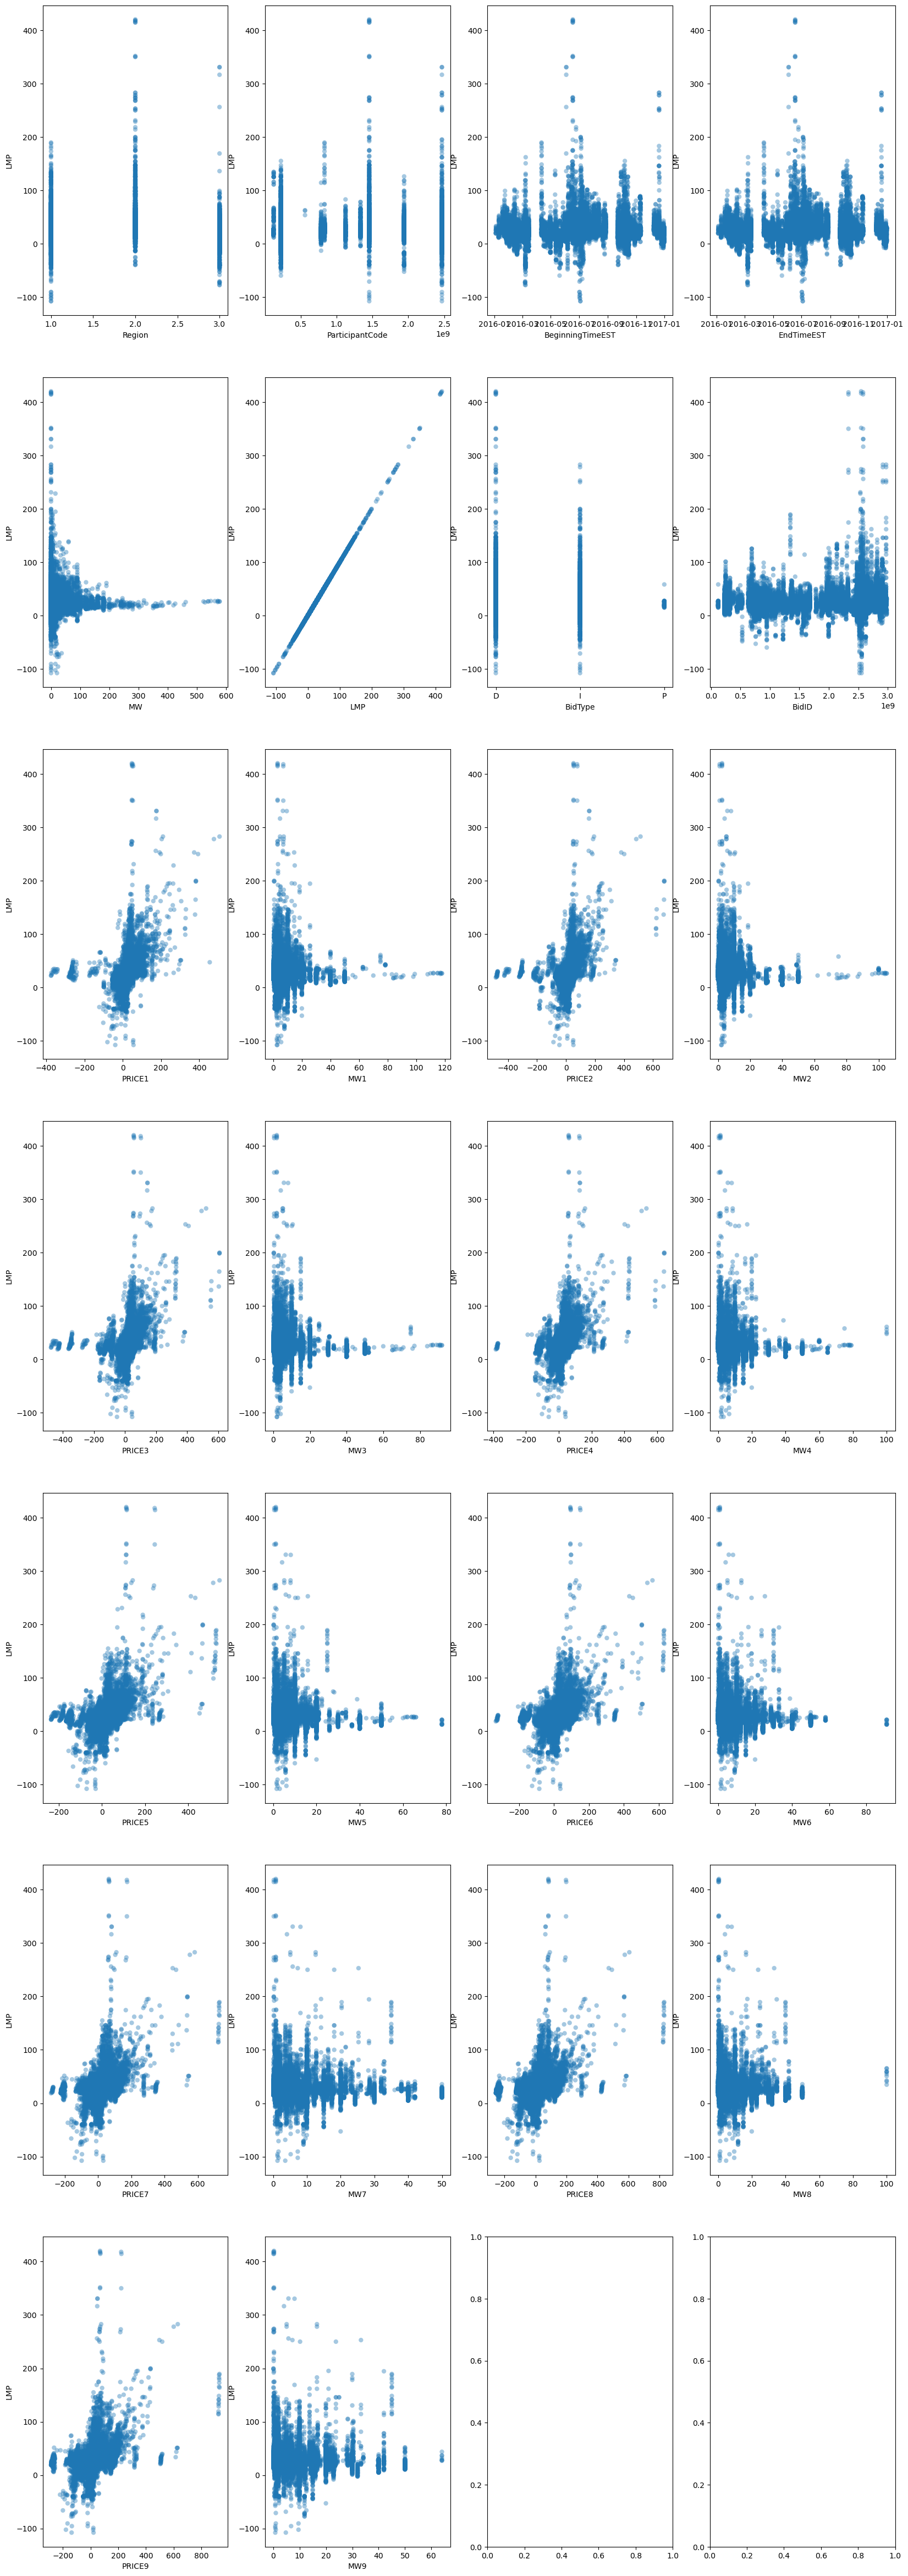

In [38]:
# Distribution of different features in comparison with the target 
# variable is illustrated below.
# Set up the figure
fig, ax = plt.subplots(nrows=7, ncols=4, figsize=(20, 60))
cols = miso_bids_df.columns
# Show each boxplot
for i, ax in enumerate(ax.flatten()):
    try:
        sns.scatterplot(x = cols[i], y = "LMP", data = miso_bids_df, 
                        ax = ax, edgecolor='none', alpha=0.4)
        plt.xticks(cols[i])
    except:
        pass

# Show the figure
plt.show()

LMP plotted with each feature:

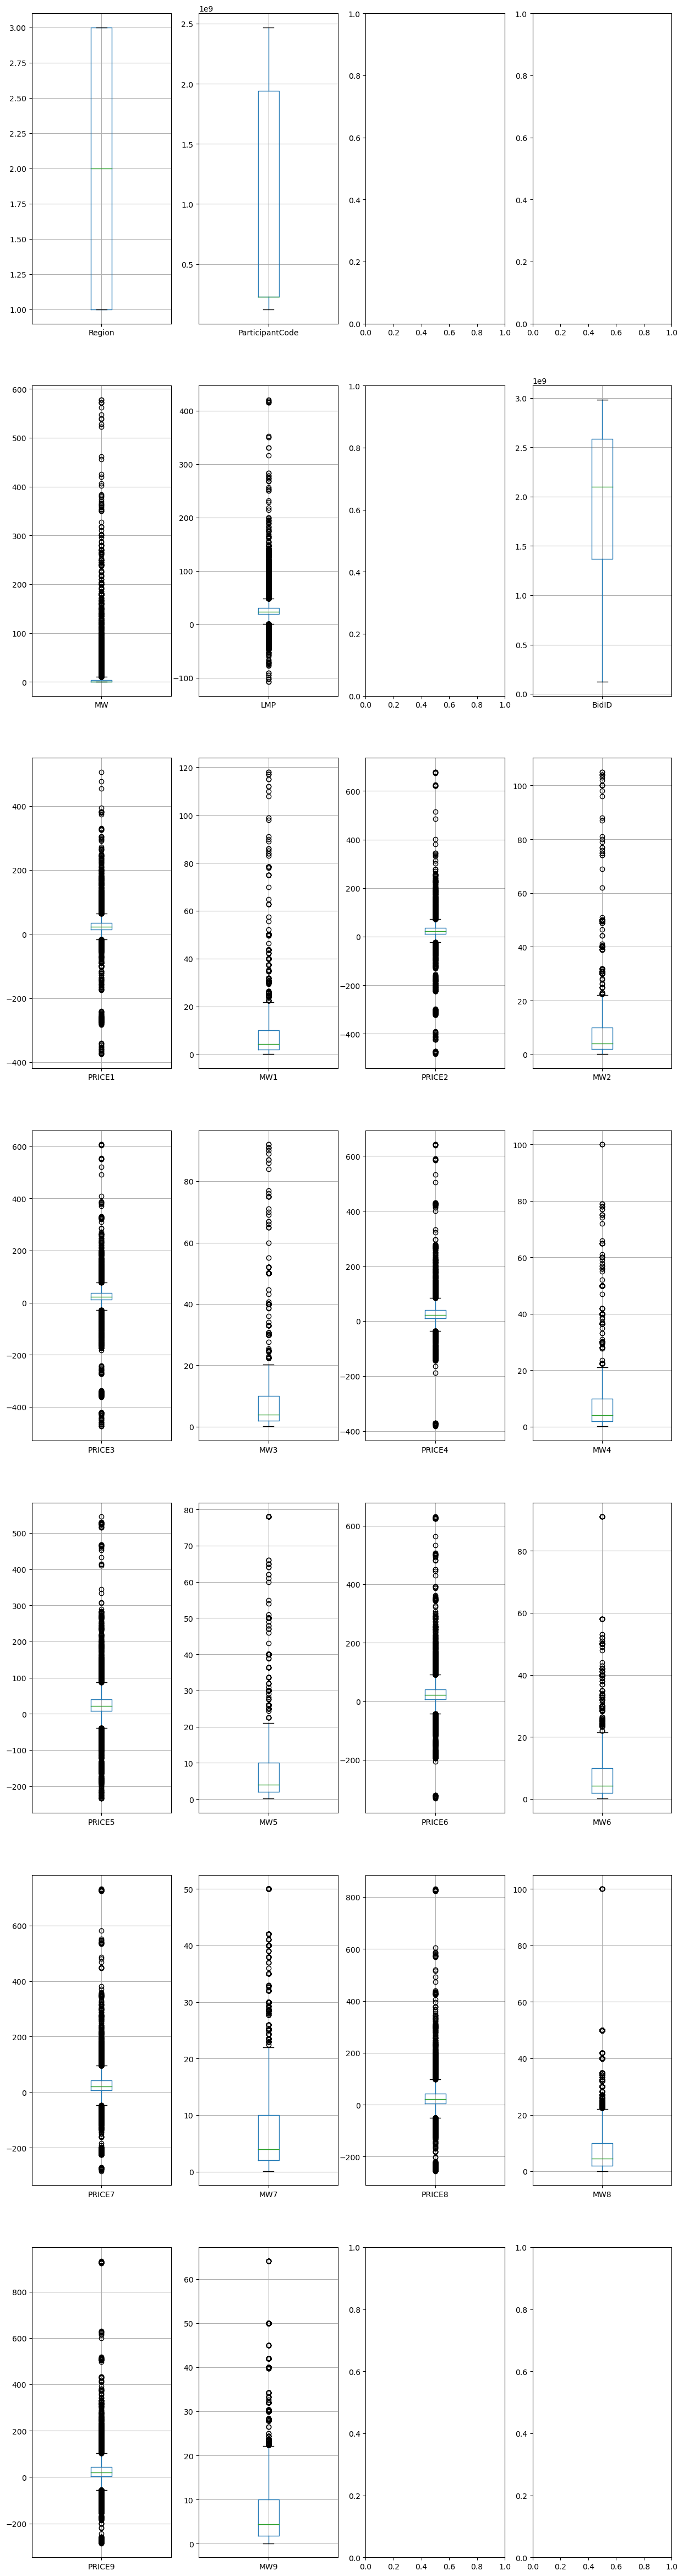

In [39]:
# Dropping the outliers
# Set up the figure
fig, ax = plt.subplots(nrows=7, ncols=4, figsize=(15, 60))

# Show each boxplot
for i, ax in enumerate(ax.flatten()):
    try:
        miso_bids_df.iloc[:,[i]].boxplot(ax=ax)
    except:
        pass

# Show the figure
plt.show()

In [24]:
from sklearn.ensemble import IsolationForest

miso_bids_if = miso_bids_df[['LMP','Region','MW','PRICE1','MW1','PRICE2','MW2',
                             'PRICE3','MW3','PRICE4','MW4','PRICE5','MW5','PRICE6',
                             'MW6','PRICE7','MW7','PRICE8','MW8','PRICE9','MW9']]

#Train an Isolation Forest
model = IsolationForest(contamination = 0.1)
model.fit(miso_bids_if)

#Predict anomalies
predictions = model.predict(miso_bids_if)

# Get the indices of the rows with positive value in predictions
positive_indices = [i for i, x in enumerate(predictions) if x>0]

# Subset the dataframe using the indices
df_trimmed = miso_bids_if.iloc[positive_indices]

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [26]:
miso_bids_if.shape

(47730, 21)

In [27]:
df_trimmed.shape

(42957, 21)

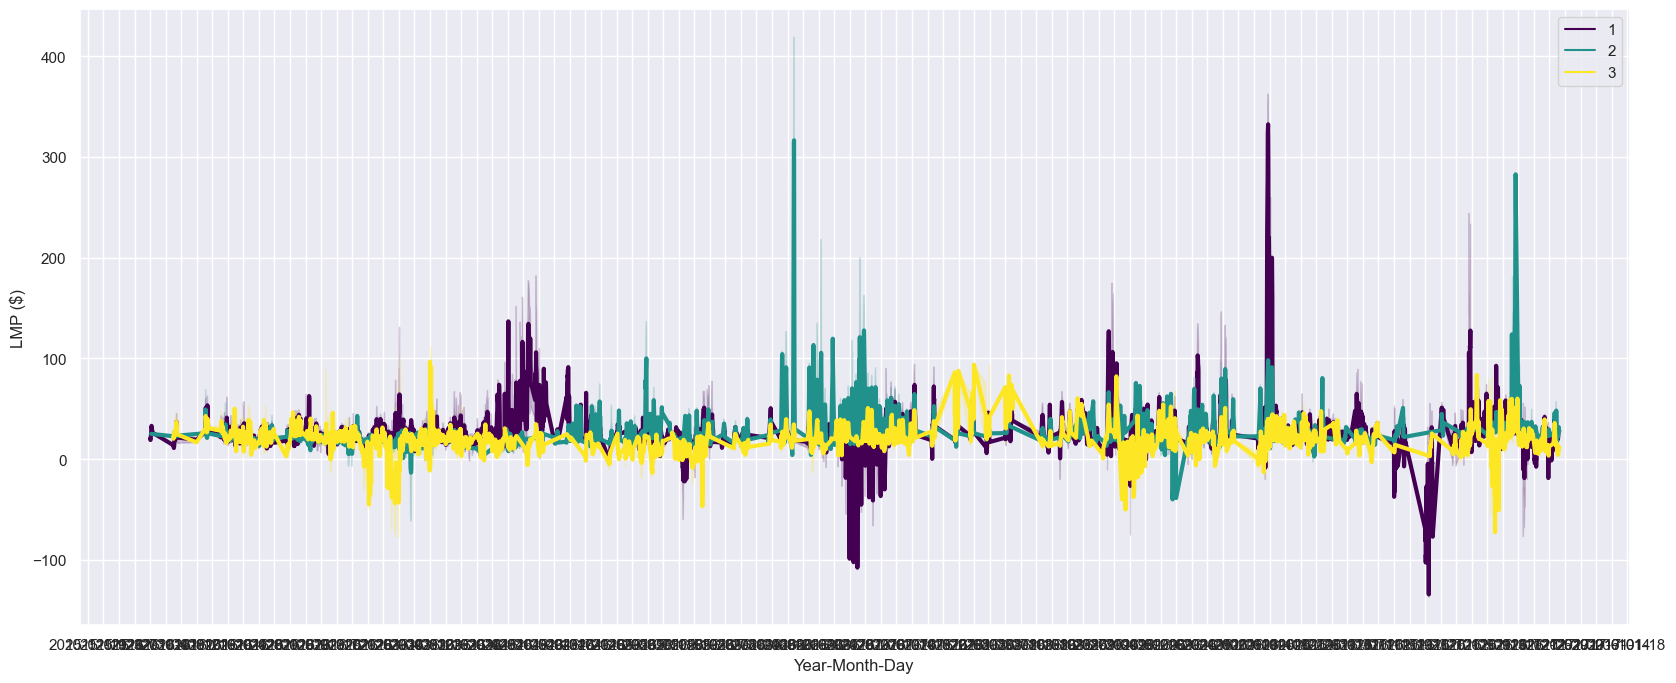

In [28]:
# Time series plot
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(20,8)})

ax = sns.lineplot(data=miso_bids_df, x = 'BeginningTimeEST', y = 'LMP', 
                  hue='Region', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('LMP ($)')
plt.xlabel('Year-Month-Day')
plt.show()

Time series plot LMP

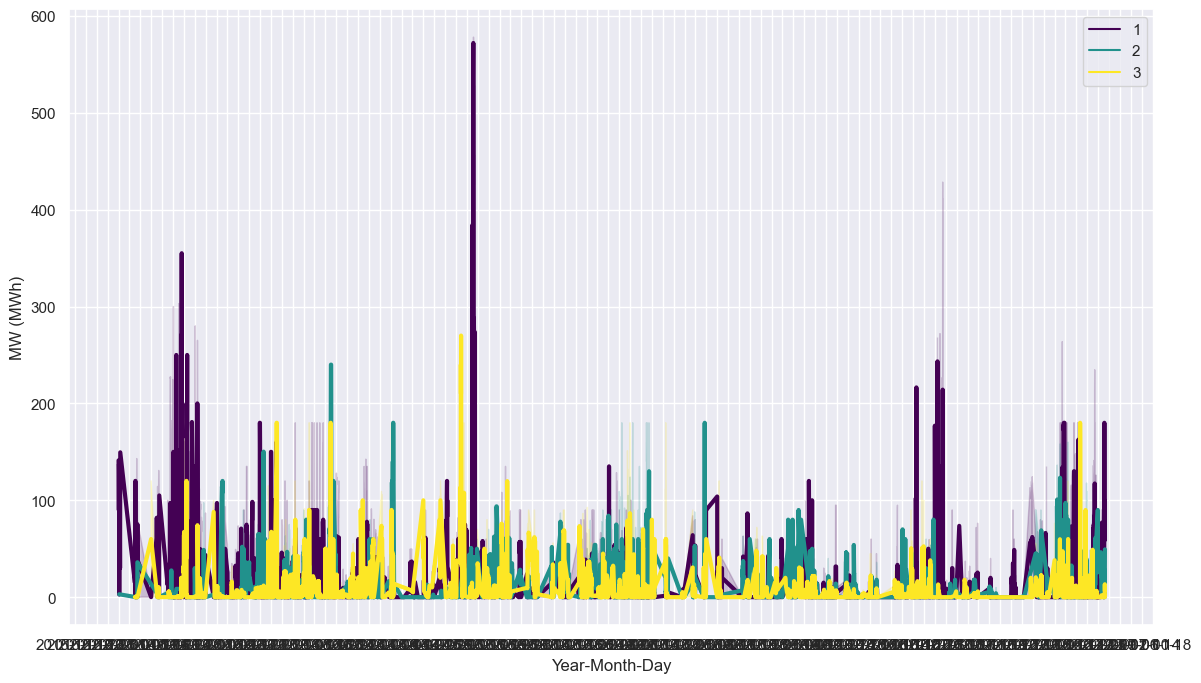

In [29]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=miso_bids_df, x = 'BeginningTimeEST', y = 'MW', 
                  hue='Region', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('MW (MWh)')
plt.xlabel('Year-Month-Day')
plt.show()

Time series plot MW

In [30]:
# Histogram
def histogram(data, xaxis, maintitle):
    # Create the histogram
    fig, ax = plt.subplots(figsize = (6,4))
    # Plot histogram
    data.plot(kind = "hist", density = True, bins = 15) 
    # change density to true, because KDE uses density
    # Plot KDE
    data.plot(kind = "kde")
    # X #
    ax.set_xlabel(xaxis)
    # Overall #
    ax.set_title(maintitle)
    plt.show()

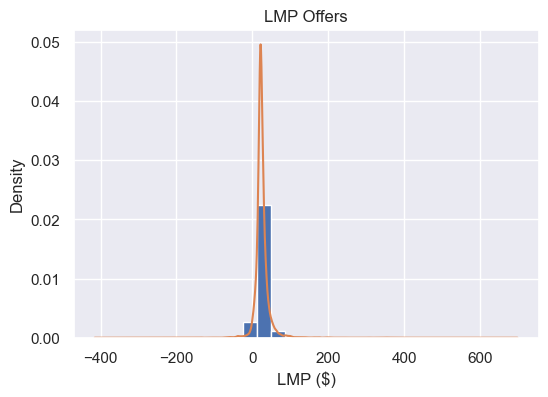

In [31]:
histogram(miso_bids_df['LMP'], 'LMP ($)', 'LMP Offers')

Histogram of LMP

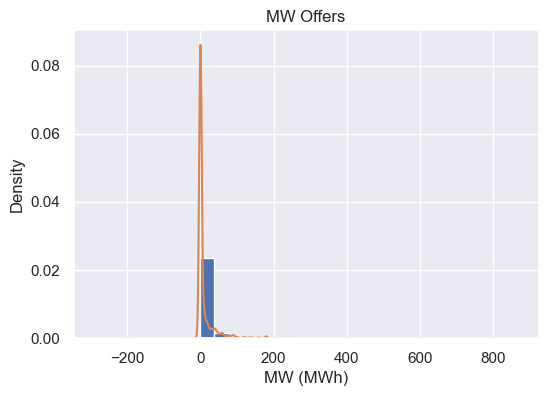

In [32]:
histogram(miso_bids_df['MW'],"MW (MWh)","MW Offers")

Histogram of MW

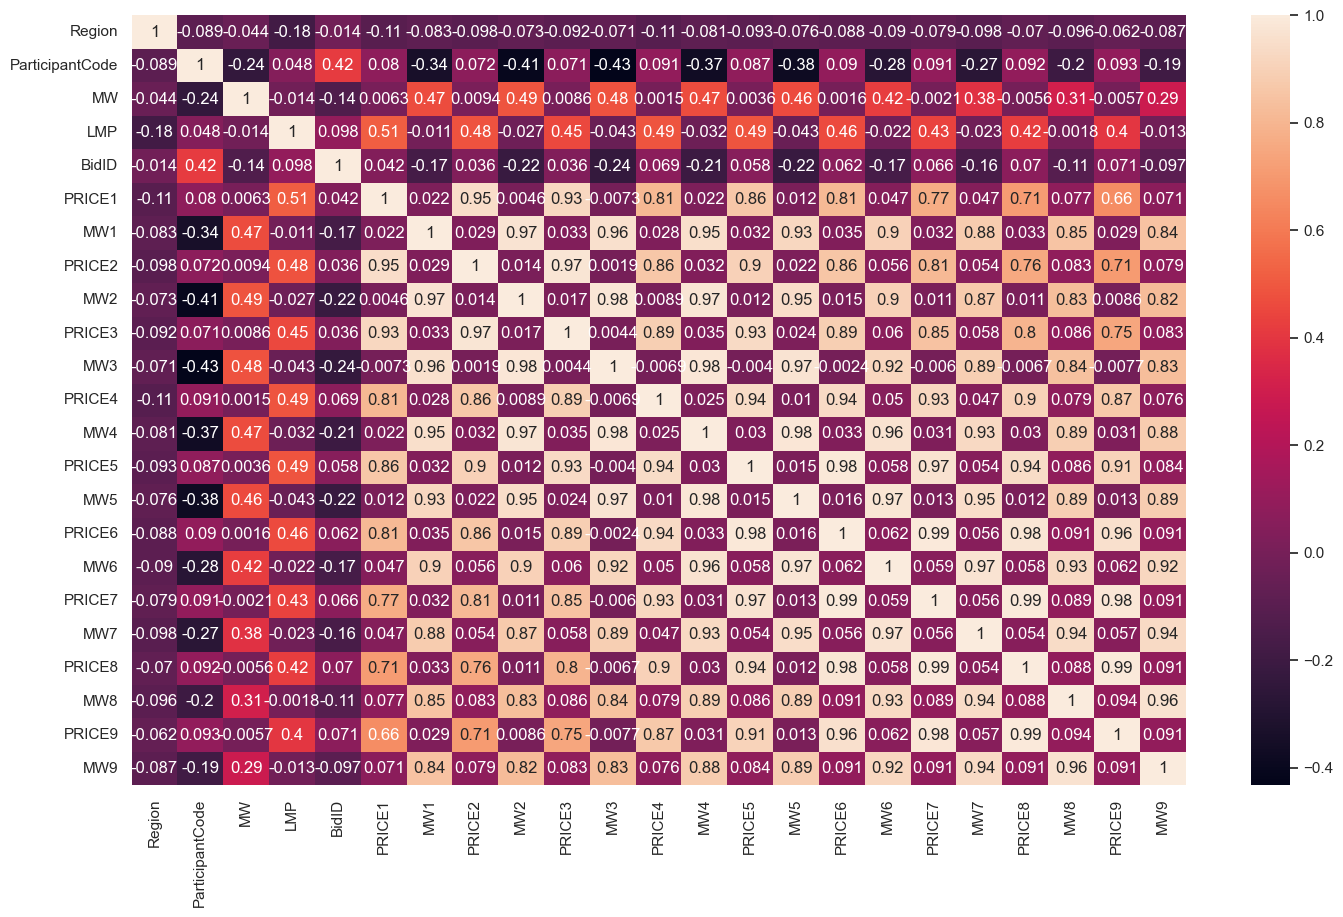

In [33]:
# Correlation Matrix
sns.set(rc={'figure.figsize':(17,10)})
corr_matrix = miso_bids_df.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [ ]:
Correlation matrix:

### Data Modelling

In [15]:
# Split target and predictors into y and x
miso_bids_x = miso_bids_df[['Region','MW','PRICE1','MW1','PRICE2','MW2','PRICE3','MW3','PRICE4',
                                'MW4','PRICE5','MW5','PRICE6','MW6','PRICE7','MW7',
                                'PRICE8','MW8','PRICE9','MW9']]
miso_bids_y = miso_bids_df['LMP']

In [16]:
miso_bids_x.head()

,Region,MW,PRICE1,MW1,PRICE2,MW2,PRICE3,MW3,PRICE4,MW4,PRICE5,MW5,PRICE6,MW6,PRICE7,MW7,PRICE8,MW8,PRICE9,MW9
135,3,0.0,17.61,1.0,16.70,1.0,15.78,1.0,14.86,1.0,13.94,1.0,13.02,1.0,12.11,1.0,11.19,1.0,10.27,1.0
136,3,0.0,16.89,1.0,15.71,1.0,14.53,1.0,13.35,1.0,12.17,1.0,10.99,1.0,9.80,1.0,8.62,1.0,7.44,1.0
137,3,6.0,22.95,1.0,21.97,1.0,20.99,1.0,20.01,1.0,19.04,1.0,18.06,1.0,17.08,1.0,16.11,1.0,15.13,1.0
138,3,5.0,41.45,1.0,39.67,1.0,37.90,1.0,36.12,1.0,34.34,1.0,32.57,1.0,30.79,1.0,29.01,1.0,27.24,1.0
139,3,5.0,25.48,1.0,24.92,1.0,24.37,1.0,23.82,1.0,23.27,1.0,22.72,1.0,22.16,1.0,21.61,1.0,21.06,1.0


In [17]:
miso_bids_y.head()

135    19.78
136    18.05
137    17.88
138    33.19
139    22.83
Name: LMP, dtype: float64

#### Training and Testing

In [11]:
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [12]:
# Here, I am using MinMaxScaler to scale the data
miso_bids_if = miso_bids_df[['LMP','MW','PRICE1','MW1','PRICE2','MW2','PRICE3','MW3','PRICE4',
                            'MW4','PRICE5','MW5','PRICE6','MW6','PRICE7','MW7',
                            'PRICE8','MW8','PRICE9','MW9']]

scaler = MinMaxScaler()
bids_sc = miso_bids_if.copy()
bids_sc = pd.DataFrame(scaler.fit_transform(bids_sc), columns=bids_sc.columns)
bids_sc.head()

,LMP,MW,PRICE1,MW1,PRICE2,MW2,PRICE3,MW3,PRICE4,MW4,PRICE5,MW5,PRICE6,MW6,PRICE7,MW7,PRICE8,MW8,PRICE9,MW9
0,0.281417,0.000000,0.473374,0.007634,0.400839,0.00858,0.453555,0.009793,0.270803,0.011407,0.325392,0.011553,0.315683,0.009901,0.308787,0.018036,0.303482,0.009009,0.299288,0.014085
1,0.278311,0.000000,0.472507,0.007634,0.399942,0.00858,0.452401,0.009793,0.269049,0.011407,0.323083,0.011553,0.313435,0.009901,0.306566,0.018036,0.301298,0.009009,0.297134,0.014085
2,0.278006,0.010381,0.479804,0.007634,0.405617,0.00858,0.458365,0.009793,0.276785,0.011407,0.332046,0.011553,0.321264,0.009901,0.313565,0.018036,0.307662,0.009009,0.302986,0.014085
3,0.305487,0.008651,0.502083,0.007634,0.421662,0.00858,0.473978,0.009793,0.295498,0.011407,0.352007,0.011553,0.337331,0.009901,0.326747,0.018036,0.318621,0.009009,0.312202,0.014085
4,0.286891,0.008651,0.482851,0.007634,0.408291,0.00858,0.461486,0.009793,0.281211,0.011407,0.337565,0.011553,0.326424,0.009901,0.318450,0.018036,0.312334,0.009009,0.307499,0.014085


In [13]:
# Here I am splitting the scaled dataset into X and Y dataframes
bids_x_scaled = bids_sc[['MW','PRICE1','MW1','PRICE2','MW2','PRICE3','MW3','PRICE4',
                            'MW4','PRICE5','MW5','PRICE6','MW6','PRICE7','MW7',
                            'PRICE8','MW8','PRICE9','MW9']]
bids_y_scaled = bids_sc['LMP']

In [18]:
# create training and testing vars for non-scaled data
X_train, X_test, y_train, y_test = train_test_split(miso_bids_x, 
                                                    miso_bids_y, test_size=0.4)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(23973, 20) (23973,)
(15982, 20) (15982,)


In [19]:
# create training and testing vars for scaled data
X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(bids_x_scaled, 
                                                                bids_y_scaled, 
                                                                test_size=0.4)
print(X_train_sc.shape, y_train_sc.shape)
print(X_test_sc.shape, y_test_sc.shape)

(23973, 19) (23973,)
(15982, 19) (15982,)


#### Linear Regression

In [33]:
from sklearn.linear_model import LinearRegression

In [34]:
# Initilizing a Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [36]:
# Printing out the coefficient of determination, intercepts, and slope for the 
# Linear Regression model
# Calculating the R^2 (coefficient of determination) for the training and testing data
from sklearn.metrics import r2_score

train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

# Calculating Mean Squared Error (MSE)
train_mse = mean_squared_error(y_test, train_preds)
test_mse = mean_squared_error(y_test, test_preds)

# Calculating Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

# Calculating R-squared (coefficient of determination)
train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)

print("Train Mean Squared Error (MSE):", train_mse)
print("Test Mean Squared Error (MSE):", test_mse)
print("Train Root Mean Squared Error (RMSE):", train_rmse)
print("Test Root Mean Squared Error (RMSE):", test_rmse)
print(f"Train R^2: {train_r2}")
print(f"Test R^2: {test_r2}")

print("  ")

print(f"intercept: {model.intercept_}")
importance = np.abs(model.coef_)
feature_names = X_train.columns

print("  ")

# Print feature importance scores
print("Coeffecients:")
for name, score in zip(feature_names, importance):
    print(name, score)

ValueError: Found input variables with inconsistent numbers of samples: [15982, 23973]

Text(0, 0.5, 'Predictions')

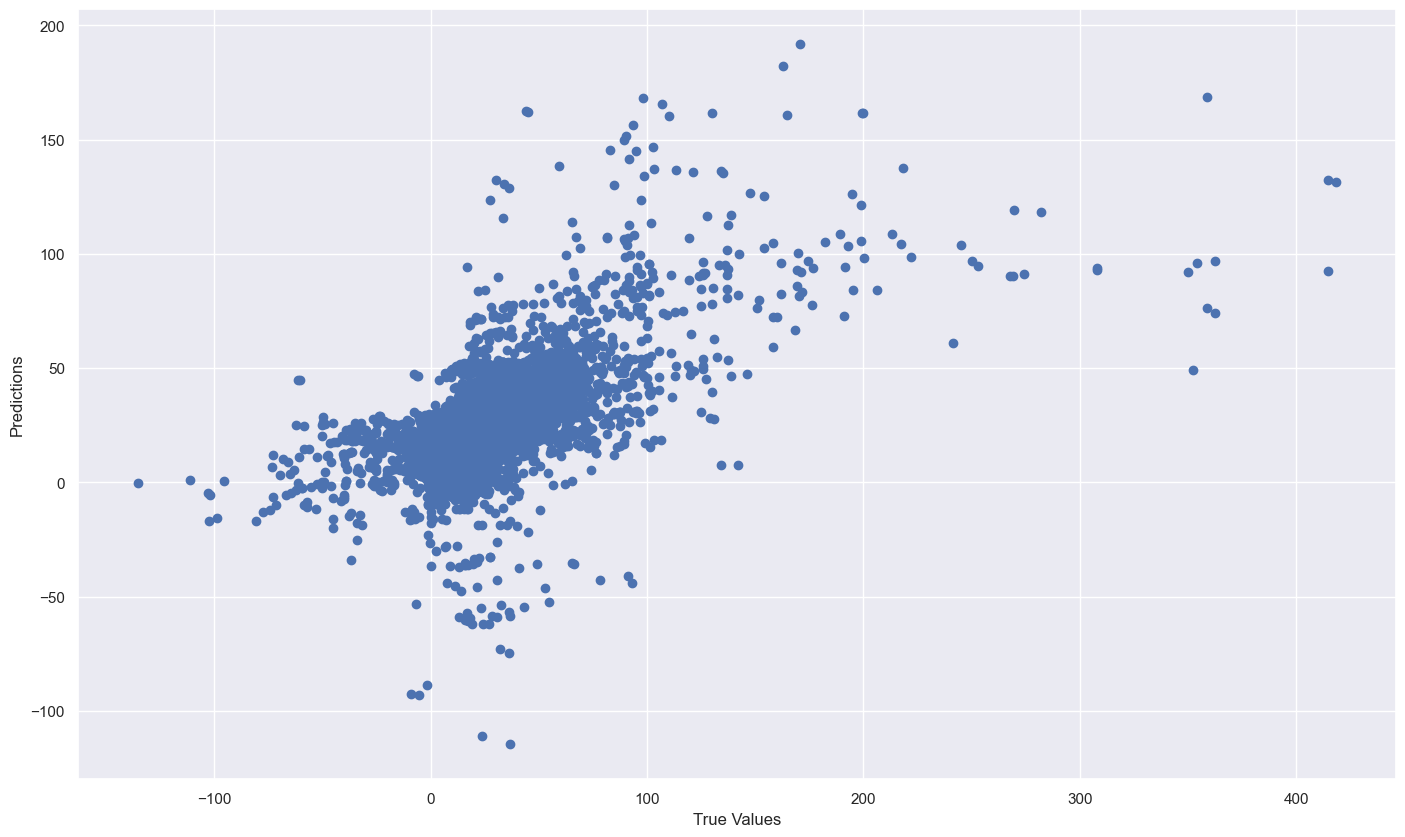

In [49]:
# Making predictions to test the model and plotting the predictions against the true values
predictions = model.predict(X_test)

## The line / model
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [50]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import numpy as np

# Initilizing a Linear Regression Model
model = LinearRegression()

# Define the range of number of features to consider for RFE
n_features_range = range(1, X_train.shape[1]+1)

# Set up cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Find the best number of features using RFECV
rfe_cv = RFECV(estimator=model, step=1, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
rfe_cv.fit(X_train, y_train)

# Get the optimal number of features
n_features_optimal = rfe_cv.n_features_

# Print the results
print("Optimal number of features: %d" % n_features_optimal)
print("Ranking of features: %s" % rfe_cv.ranking_)

Optimal number of features: 16
Ranking of features: [1 5 1 1 1 1 1 1 1 1 1 1 3 1 1 2 1 1 4 1]


In [51]:
# Recursive feature elimination (RFE) from scikit-learn
from sklearn.feature_selection import RFE

# Select top 25 features
rfe = RFE(model, n_features_to_select=16)
rfe.fit(X_train, y_train)

print(f"Selected Features: {X_train.columns[rfe.support_]}")

Selected Features: Index(['Region', 'PRICE1', 'MW1', 'PRICE2', 'MW2', 'PRICE3', 'MW3', 'PRICE4',
       'MW4', 'PRICE5', 'MW5', 'MW6', 'PRICE7', 'PRICE8', 'MW8', 'MW9'],
      dtype='object')


In [52]:
r_sq = rfe.score(X_test, y_test)
print(f"coefficient of determination: {r_sq}")

coefficient of determination: 0.382136768289421


Text(0, 0.5, 'Predictions')

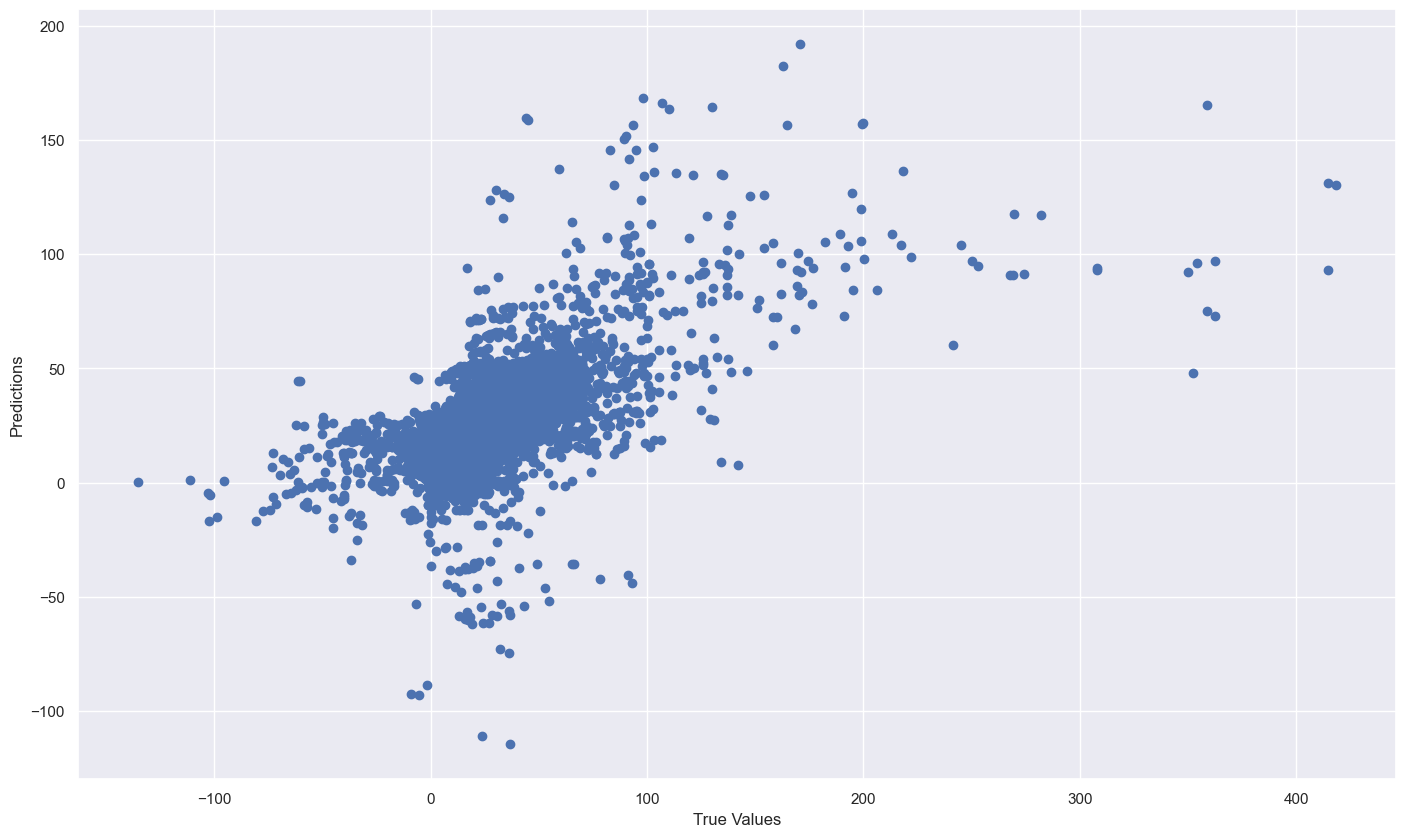

In [53]:
# Making predictions to test the model and plotting the predictions against the true values
predictions = rfe.predict(X_test)
## The line / model
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [54]:
# Lasso regularization from scikit-learn
from sklearn.linear_model import Lasso

# Apply Lasso regularization
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)

# Get feature importance scores
importance = np.abs(lasso.coef_)
feature_names = X_train.columns

# Print feature importance scores
print("Feature Importance Scores:")
for name, score in zip(feature_names, importance):
    print(name, score)

Feature Importance Scores:
Region 2.517360818668555
MW 0.008567636110084119
PRICE1 0.39186139522847335
MW1 0.23658359342390095
PRICE2 0.15607546313029322
MW2 0.35997685669922125
PRICE3 0.5855479910595789
MW3 0.13695547482075004
PRICE4 0.29892771579574917
MW4 0.31962211964200965
PRICE5 0.8297452678667392
MW5 0.3015653636177324
PRICE6 0.05469493263707487
MW6 0.16226696065302393
PRICE7 1.3911515484395525
MW7 0.0677786267683389
PRICE8 0.7968928170640162
MW8 0.19672802762476557
PRICE9 0.03313279963136397
MW9 0.37831560548985815


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.015e+06, tolerance: 1.191e+03
  model = cd_fast.enet_coordinate_descent(


#### Random Forest

Train accuracy: 0.9752283701073233
Test accuracy: 0.8681835208149521
 


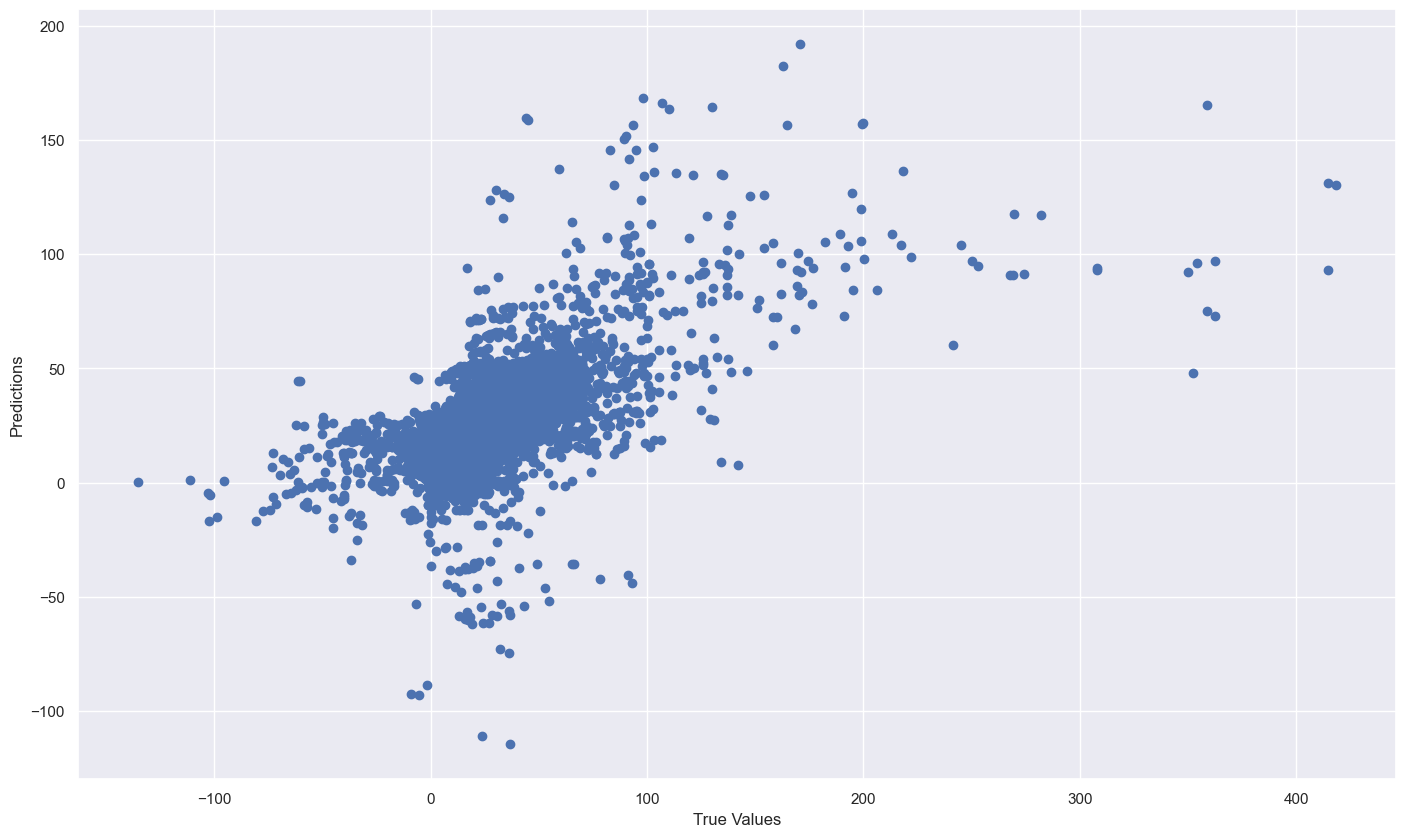

In [57]:
from sklearn.ensemble import RandomForestRegressor

def random_forest(X, y, n_estimators=100):
    # Create a random forest regressor
    model = RandomForestRegressor(n_estimators=n_estimators)

    # Fit the model to the data
    model.fit(X, y)

    return model

model = random_forest(X_train, y_train)

# Make predictions
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

# Calculating Mean Squared Error (MSE)
train_mse = mean_squared_error(y_test, train_pred)
test_mse = mean_squared_error(y_test, test_pred)

# Calculating Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

# Calculating R-squared (coefficient of determination)
train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)

print("Train Mean Squared Error (MSE):", train_mse)
print("Test Mean Squared Error (MSE):", test_mse)
print("Train Root Mean Squared Error (RMSE):", train_rmse)
print("Test Root Mean Squared Error (RMSE):", test_rmse)
print(f"Train R^2: {train_r2}")
print(f"Test R^2: {test_r2}")

print(" ")

## The line / model
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
r_sq = model.score(X_test, y_test)

#### Decision Tree

Train accuracy: 0.9938092319225325
Test accuracy: 0.7706476136725391
 


Text(0, 0.5, 'Predictions')

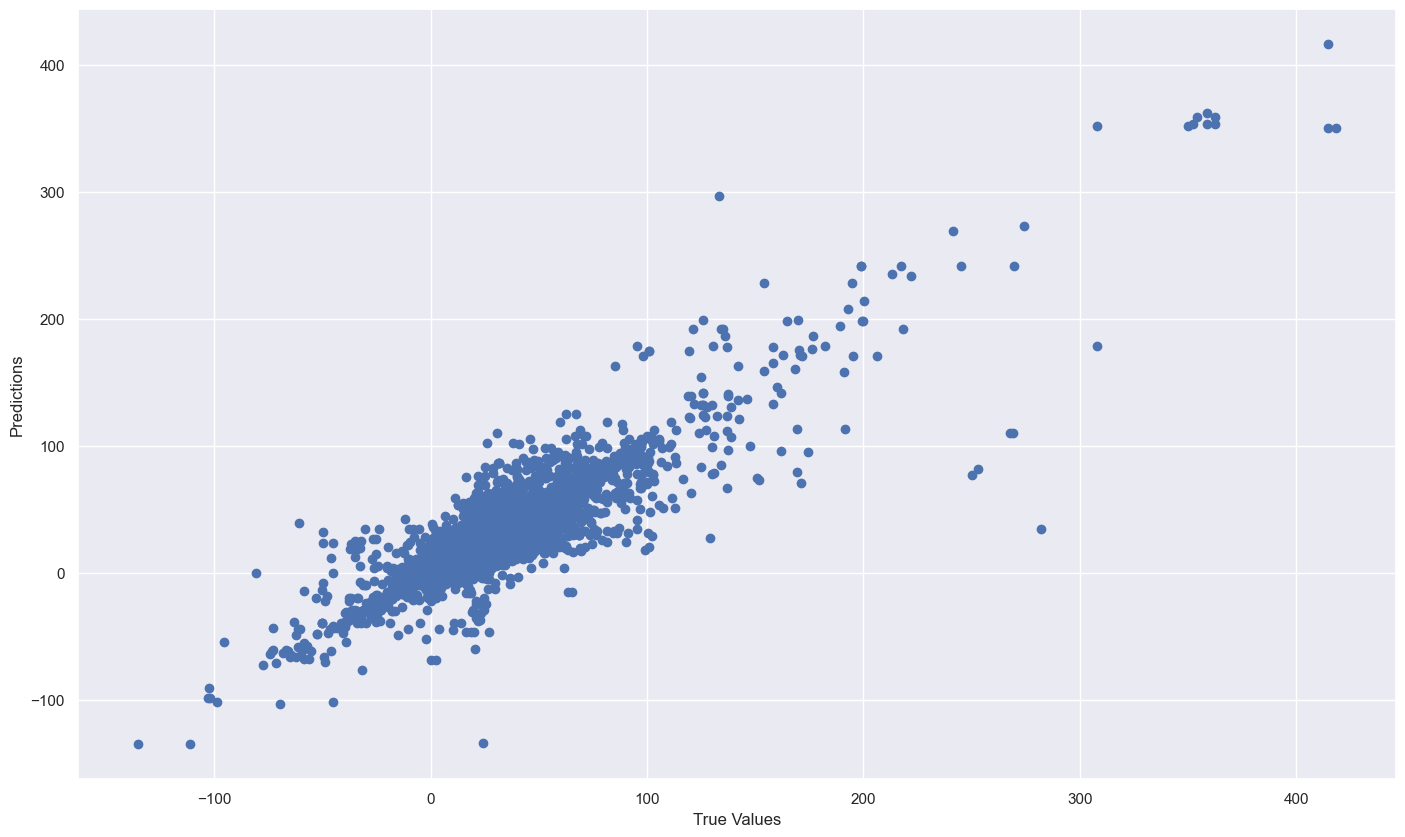

In [59]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialize and fit the decision tree model
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# Make predictions
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

# Calculating Mean Squared Error (MSE)
train_mse = mean_squared_error(y_test, train_pred)
test_mse = mean_squared_error(y_test, test_pred)

# Calculating Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

# Calculating R-squared (coefficient of determination)
train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)

print("Train Mean Squared Error (MSE):", train_mse)
print("Test Mean Squared Error (MSE):", test_mse)
print("Train Root Mean Squared Error (RMSE):", train_rmse)
print("Test Root Mean Squared Error (RMSE):", test_rmse)
print(f"Train R^2: {train_r2}")
print(f"Test R^2: {test_r2}")

print(" ")

## The line / model
plt.scatter(y_test, test_preds)
plt.xlabel('True Values')
plt.ylabel('Predictions')

Mean squared error: 184.38
Coefficient of determination: 0.55
Selected features: Index(['PRICE1', 'PRICE2', 'PRICE4', 'PRICE5', 'PRICE6'], dtype='object')
Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 2}
 
Train accuracy: 0.6351100819984924
Test accuracy: 0.5455394008508225
 


Text(0, 0.5, 'Predictions')

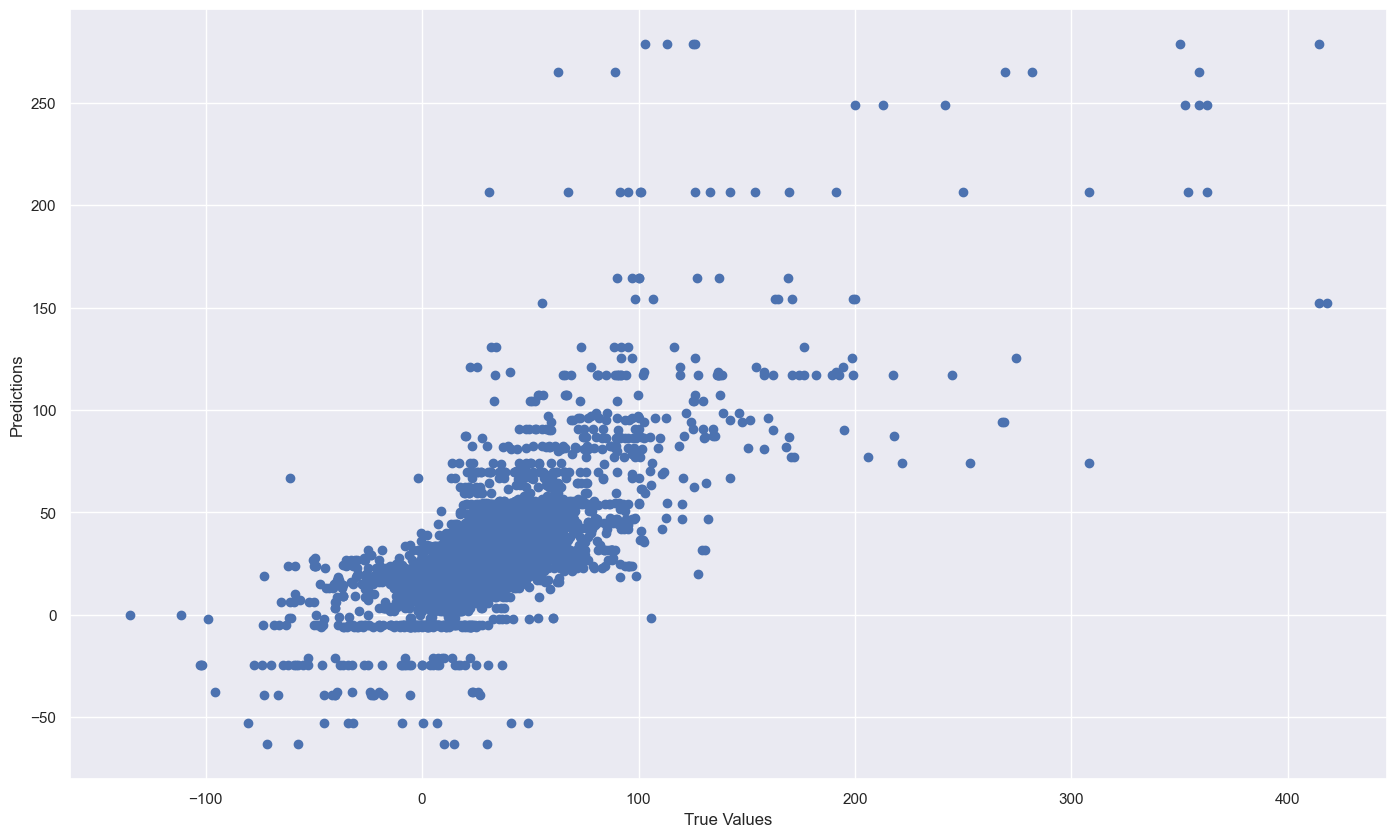

In [60]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression

# Feature selection using SelectKBest with f_regression
selector = SelectKBest(f_regression, k=5)
X_train_sel = selector.fit_transform(X_train, y_train)
X_test_sel = selector.transform(X_test)
selected_features = X_train.columns[selector.get_support()]

# Define the hyperparameter grid for GridSearchCV
param_grid = {
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8],
}

# Initialize and fit the decision tree model with GridSearchCV
model = DecisionTreeRegressor(random_state=0)
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5)
grid_search.fit(X_train_sel, y_train)

# Use the best model to make predictions on test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_sel)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean squared error: {mse:.2f}")
print(f"Coefficient of determination: {r2:.2f}")
print(f"Selected features: {selected_features}")
print(f"Best hyperparameters: {grid_search.best_params_}")

print(" ")

# Make predictions
train_preds = best_model.predict(X_train_sel)
test_preds = best_model.predict(X_test_sel)

# Calculating Mean Squared Error (MSE)
train_mse = mean_squared_error(y_test, train_pred)
test_mse = mean_squared_error(y_test, test_pred)

# Calculating Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

# Calculating R-squared (coefficient of determination)
train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)

print("Train Mean Squared Error (MSE):", train_mse)
print("Test Mean Squared Error (MSE):", test_mse)
print("Train Root Mean Squared Error (RMSE):", train_rmse)
print("Test Root Mean Squared Error (RMSE):", test_rmse)
print(f"Train R^2: {train_r2}")
print(f"Test R^2: {test_r2}")

print(" ")

## The line / model
plt.scatter(y_test, test_preds)
plt.xlabel('True Values')
plt.ylabel('Predictions')

#### Simple Neural Network

In [62]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers

def neural_network(X, y):
    # Define the model
    model = models.Sequential()
    model.add(layers.Dense(50, activation='relu', input_shape=[19]))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))

    # Output layer
    model.add(layers.Dense(1))

    # Compile the model
    model.compile(loss='mean_squared_error', 
                  optimizer='adam', 
                  metrics=['accuracy'])

    # Fit the model to the data
    history = model.fit(X, y, epochs=150)

    return model

model = neural_network(X_train_sc, y_train_sc)

Epoch 1/150
895/895 [==============================] - 3s 2ms/step - loss: 0.0011 - accuracy: 6.9837e-05
Epoch 2/150
895/895 [==============================] - 2s 2ms/step - loss: 8.6008e-04 - accuracy: 6.9837e-05
Epoch 3/150
895/895 [==============================] - 2s 2ms/step - loss: 8.1563e-04 - accuracy: 6.9837e-05
Epoch 4/150
895/895 [==============================] - 2s 2ms/step - loss: 7.7636e-04 - accuracy: 6.9837e-05
Epoch 5/150
895/895 [==============================] - 2s 2ms/step - loss: 7.4755e-04 - accuracy: 6.9837e-05
Epoch 6/150
895/895 [==============================] - 2s 2ms/step - loss: 7.4196e-04 - accuracy: 6.9837e-05
Epoch 7/150
895/895 [==============================] - 2s 2ms/step - loss: 7.0124e-04 - accuracy: 6.9837e-05
Epoch 8/150
895/895 [==============================] - 2s 2ms/step - loss: 6.7492e-04 - accuracy: 6.9837e-05
Epoch 9/150
895/895 [==============================] - 2s 2ms/step - loss: 6.6098e-04 - accuracy: 6.9837e-05
Epoch 10/150
895/895 [=

895/895 [==============================] - 2s 2ms/step - loss: 3.2950e-04 - accuracy: 6.9837e-05
Epoch 150/150
895/895 [==============================] - 2s 2ms/step - loss: 3.3670e-04 - accuracy: 6.9837e-05


In [63]:
# Make predictions
train_preds = model.predict(X_train_sc)
test_preds = model.predict(X_test_sc)

# Calculating Mean Squared Error (MSE)
train_mse = mean_squared_error(y_test, train_pred)
test_mse = mean_squared_error(y_test, test_pred)

# Calculating Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

# Calculating R-squared (coefficient of determination)
train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)

print("Train Mean Squared Error (MSE):", train_mse)
print("Test Mean Squared Error (MSE):", test_mse)
print("Train Root Mean Squared Error (RMSE):", train_rmse)
print("Test Root Mean Squared Error (RMSE):", test_rmse)
print(f"Train R^2: {train_r2}")
print(f"Test R^2: {test_r2}")

597/597 [==============================] - 1s 2ms/step
Train accuracy: 0.7756453356697326
Test accuracy: 0.7373602691532195


##### RNN

In [20]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

def rnn(X_train, y_train, X_test, y_test):
    
    # Define the model
    model = tf.keras.Sequential()
    model.add(layers.SimpleRNN(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(layers.SimpleRNN(units=32, return_sequences=True))
    model.add(layers.SimpleRNN(units=16))
    model.add(layers.Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

    # Fit the model to the data
    history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test))

    return model, history

In [21]:
rnn_model = rnn(X_train, y_train, X_test, y_test)

2023-07-12 22:51:07.422950: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/200
750/750 [==============================] - 21s 23ms/step - loss: 599.3354 - accuracy: 1.2514e-04 - val_loss: 499.3564 - val_accuracy: 2.5028e-04
Epoch 2/200
750/750 [==============================] - 21s 28ms/step - loss: 380.8871 - accuracy: 2.5028e-04 - val_loss: 386.7375 - val_accuracy: 3.7542e-04
Epoch 3/200
750/750 [==============================] - 22s 30ms/step - loss: 310.4324 - accuracy: 2.5028e-04 - val_loss: 334.4778 - val_accuracy: 3.1285e-04
Epoch 4/200
750/750 [==============================] - 19s 25ms/step - loss: 283.1646 - accuracy: 2.5028e-04 - val_loss: 325.0486 - val_accuracy: 3.7542e-04
Epoch 5/200
750/750 [==============================] - 17s 22ms/step - loss: 272.6203 - accuracy: 2.9200e-04 - val_loss: 314.0966 - val_accuracy: 3.1285e-04
Epoch 6/200
750/750 [==============================] - 18s 24ms/step - loss: 263.7215 - accuracy: 2.5028e-04 - val_loss: 305.7880 - val_accuracy: 3.7542e-04
Epoch 7/200
750/750 [==============================] - 21s

Epoch 53/200
750/750 [==============================] - 14s 19ms/step - loss: 181.7627 - accuracy: 4.5885e-04 - val_loss: 234.9115 - val_accuracy: 4.3799e-04
Epoch 54/200
750/750 [==============================] - 14s 19ms/step - loss: 210.3779 - accuracy: 4.5885e-04 - val_loss: 279.9502 - val_accuracy: 3.7542e-04
Epoch 55/200
750/750 [==============================] - 14s 18ms/step - loss: 211.5905 - accuracy: 3.3371e-04 - val_loss: 239.9963 - val_accuracy: 3.7542e-04
Epoch 56/200
750/750 [==============================] - 14s 19ms/step - loss: 191.7973 - accuracy: 2.5028e-04 - val_loss: 241.7708 - val_accuracy: 3.1285e-04
Epoch 57/200
750/750 [==============================] - 14s 19ms/step - loss: 186.7060 - accuracy: 2.0857e-04 - val_loss: 238.2088 - val_accuracy: 4.3799e-04
Epoch 58/200
750/750 [==============================] - 15s 19ms/step - loss: 190.3442 - accuracy: 2.9200e-04 - val_loss: 242.5025 - val_accuracy: 3.1285e-04
Epoch 59/200
750/750 [==============================

Epoch 105/200
750/750 [==============================] - 15s 20ms/step - loss: 171.5738 - accuracy: 2.9200e-04 - val_loss: 207.3818 - val_accuracy: 3.7542e-04
Epoch 106/200
750/750 [==============================] - 15s 20ms/step - loss: 166.3794 - accuracy: 2.9200e-04 - val_loss: 205.1434 - val_accuracy: 3.7542e-04
Epoch 107/200
750/750 [==============================] - 15s 20ms/step - loss: 165.2340 - accuracy: 2.5028e-04 - val_loss: 215.0885 - val_accuracy: 3.1285e-04
Epoch 108/200
750/750 [==============================] - 15s 19ms/step - loss: 187.3221 - accuracy: 2.9200e-04 - val_loss: 214.8935 - val_accuracy: 3.7542e-04
Epoch 109/200
750/750 [==============================] - 14s 19ms/step - loss: 171.5974 - accuracy: 2.9200e-04 - val_loss: 339.1357 - val_accuracy: 1.8771e-04
Epoch 110/200
750/750 [==============================] - 15s 20ms/step - loss: 219.5818 - accuracy: 8.3427e-05 - val_loss: 235.0384 - val_accuracy: 3.1285e-04
Epoch 111/200
750/750 [=======================

In [22]:
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions
train_preds = rnn_model[0].predict(X_train)
test_preds = rnn_model[0].predict(X_test)

# Calculating Mean Squared Error (MSE)
train_mse = mean_squared_error(y_test, train_pred)
test_mse = mean_squared_error(y_test, test_pred)

# Calculating Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

# Calculating R-squared (coefficient of determination)
train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)

print("Train Mean Squared Error (MSE):", train_mse)
print("Test Mean Squared Error (MSE):", test_mse)
print("Train Root Mean Squared Error (RMSE):", train_rmse)
print("Test Root Mean Squared Error (RMSE):", test_rmse)
print(f"Train R^2: {train_r2}")
print(f"Test R^2: {test_r2}")

500/500 [==============================] - 4s 7ms/step
RNN Model Train accuracy: 0.41496997292539173
RNN Model Test accuracy: 0.38570571989832525


In [23]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

def rnn(X_train, y_train, X_test, y_test):

    # Define the model
    model = tf.keras.Sequential()
    model.add(layers.SimpleRNN(units=64, input_shape=(X_train.shape[1], 1)))
    model.add(layers.Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

    # Fit the model to the data
    history = model.fit(X_train, y_train, epochs=150, batch_size=32)

    return model, history

In [24]:
rnn_model2 = rnn(X_train, y_train, X_test, y_test)

Epoch 1/150
750/750 [==============================] - 9s 10ms/step - loss: 418.6634 - accuracy: 3.3371e-04
Epoch 2/150
750/750 [==============================] - 11s 14ms/step - loss: 293.7383 - accuracy: 1.2514e-04
Epoch 3/150
750/750 [==============================] - 17s 23ms/step - loss: 277.6577 - accuracy: 2.5028e-04
Epoch 4/150
750/750 [==============================] - 12s 16ms/step - loss: 306.5340 - accuracy: 8.3427e-05
Epoch 5/150
750/750 [==============================] - 11s 14ms/step - loss: 285.1305 - accuracy: 2.5028e-04
Epoch 6/150
750/750 [==============================] - 7s 10ms/step - loss: 271.0334 - accuracy: 2.5028e-04
Epoch 7/150
750/750 [==============================] - 9s 12ms/step - loss: 265.2587 - accuracy: 2.5028e-04
Epoch 8/150
750/750 [==============================] - 11s 14ms/step - loss: 262.7621 - accuracy: 2.5028e-04
Epoch 9/150
750/750 [==============================] - 12s 15ms/step - loss: 259.8340 - accuracy: 2.5028e-04
Epoch 10/150
750/750 [

In [25]:
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions
train_preds = rnn_model2[0].predict(X_train)
test_preds = rnn_model2[0].predict(X_test)

# Calculating Mean Squared Error (MSE)
train_mse = mean_squared_error(y_test, train_pred)
test_mse = mean_squared_error(y_test, test_pred)

# Calculating Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

# Calculating R-squared (coefficient of determination)
train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)

print("Train Mean Squared Error (MSE):", train_mse)
print("Test Mean Squared Error (MSE):", test_mse)
print("Train Root Mean Squared Error (RMSE):", train_rmse)
print("Test Root Mean Squared Error (RMSE):", test_rmse)
print(f"Train R^2: {train_r2}")
print(f"Test R^2: {test_r2}")

500/500 [==============================] - 2s 4ms/step
RNN Model Train accuracy: 0.3563161202907633
RNN Model Test accuracy: 0.32098477096744016


##### LSTM Model

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

def lstm_model(X_train, y_train, dropout_rate=0.2):
    model = Sequential()
    
    # Add LSTM layer with 50 units and input shape of (n_steps, n_features)
    model.add(LSTM(50, input_shape=(X_train.shape[1], 1)))
    
    # Add dropout layer to prevent overfitting
    model.add(Dropout(dropout_rate))
    
    # Add output layer with single output value
    model.add(Dense(1))
    
    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # Fit the model to the data
    model.fit(X_train, y_train, epochs=200, batch_size=16, verbose=2)
    
    return model

lstm_model = lstm_model(X_train, y_train, dropout_rate=0.2)

Epoch 1/200
1499/1499 - 31s - loss: 366.1763 - 31s/epoch - 20ms/step
Epoch 2/200
1499/1499 - 26s - loss: 275.1588 - 26s/epoch - 18ms/step
Epoch 3/200
1499/1499 - 24s - loss: 242.5667 - 24s/epoch - 16ms/step
Epoch 4/200
1499/1499 - 27s - loss: 208.1998 - 27s/epoch - 18ms/step
Epoch 5/200
1499/1499 - 20s - loss: 188.0438 - 20s/epoch - 13ms/step
Epoch 6/200
1499/1499 - 25s - loss: 174.7430 - 25s/epoch - 17ms/step
Epoch 7/200
1499/1499 - 19s - loss: 164.9184 - 19s/epoch - 13ms/step
Epoch 8/200
1499/1499 - 35s - loss: 157.2926 - 35s/epoch - 23ms/step
Epoch 9/200
1499/1499 - 35s - loss: 154.7983 - 35s/epoch - 23ms/step
Epoch 10/200
1499/1499 - 20s - loss: 149.8985 - 20s/epoch - 14ms/step
Epoch 11/200
1499/1499 - 19s - loss: 145.5580 - 19s/epoch - 13ms/step
Epoch 12/200
1499/1499 - 17s - loss: 141.8960 - 17s/epoch - 11ms/step
Epoch 13/200
1499/1499 - 22s - loss: 137.4654 - 22s/epoch - 15ms/step
Epoch 14/200
1499/1499 - 19s - loss: 133.0308 - 19s/epoch - 12ms/step
Epoch 15/200
1499/1499 - 19s 

1499/1499 - 20s - loss: 73.3416 - 20s/epoch - 14ms/step
Epoch 120/200
1499/1499 - 19s - loss: 72.7639 - 19s/epoch - 12ms/step
Epoch 121/200
1499/1499 - 18s - loss: 81.7842 - 18s/epoch - 12ms/step
Epoch 122/200
1499/1499 - 19s - loss: 74.3645 - 19s/epoch - 13ms/step
Epoch 123/200
1499/1499 - 25s - loss: 71.7536 - 25s/epoch - 16ms/step
Epoch 124/200
1499/1499 - 23s - loss: 73.4852 - 23s/epoch - 15ms/step
Epoch 125/200
1499/1499 - 22s - loss: 74.1336 - 22s/epoch - 15ms/step
Epoch 126/200
1499/1499 - 18s - loss: 73.9748 - 18s/epoch - 12ms/step
Epoch 127/200
1499/1499 - 17s - loss: 71.7731 - 17s/epoch - 11ms/step
Epoch 128/200
1499/1499 - 18s - loss: 77.3460 - 18s/epoch - 12ms/step
Epoch 129/200
1499/1499 - 23s - loss: 73.8654 - 23s/epoch - 15ms/step
Epoch 130/200
1499/1499 - 21s - loss: 71.4667 - 21s/epoch - 14ms/step
Epoch 131/200
1499/1499 - 21s - loss: 76.8643 - 21s/epoch - 14ms/step
Epoch 132/200
1499/1499 - 18s - loss: 74.2991 - 18s/epoch - 12ms/step
Epoch 133/200
1499/1499 - 17s - lo

In [27]:
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions
train_preds = lstm_model.predict(X_train)
test_preds = lstm_model.predict(X_test)

# Calculating Mean Squared Error (MSE)
train_mse = mean_squared_error(y_test, train_pred)
test_mse = mean_squared_error(y_test, test_pred)

# Calculating Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

# Calculating R-squared (coefficient of determination)
train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)

print("Train Mean Squared Error (MSE):", train_mse)
print("Test Mean Squared Error (MSE):", test_mse)
print("Train Root Mean Squared Error (RMSE):", train_rmse)
print("Test Root Mean Squared Error (RMSE):", test_rmse)
print(f"Train R^2: {train_r2}")
print(f"Test R^2: {test_r2}")

500/500 [==============================] - 3s 6ms/step
LSTM Model Train accuracy: 0.8244050977813077
LSTM Model Test accuracy: 0.7616123307243005


#### Convolutional Neural Network

In [28]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

conv_model = Sequential()

# Add a 1D convolutional layer with 32 filters, kernel size of 3 and ReLU activation
conv_model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))

# Add a max pooling layer
conv_model.add(MaxPooling1D(pool_size=2))

# Flatten the output
conv_model.add(Flatten())

# Add a fully connected layer with 100 units and ReLU activation
conv_model.add(Dense(100, activation='relu'))

# Add the output layer with sigmoid activation for binary classification
conv_model.add(Dense(1, activation='sigmoid'))

# Compile the model with binary cross-entropy loss and Adam optimizer
conv_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
conv_model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), verbose=2)


Epoch 1/200
750/750 - 8s - loss: -1.8256e+07 - accuracy: 8.3427e-05 - val_loss: -7.8614e+07 - val_accuracy: 2.5028e-04 - 8s/epoch - 10ms/step
Epoch 2/200
750/750 - 4s - loss: -2.7864e+08 - accuracy: 8.3427e-05 - val_loss: -5.9045e+08 - val_accuracy: 2.5028e-04 - 4s/epoch - 5ms/step
Epoch 3/200
750/750 - 3s - loss: -1.1089e+09 - accuracy: 8.3427e-05 - val_loss: -1.7895e+09 - val_accuracy: 2.5028e-04 - 3s/epoch - 4ms/step
Epoch 4/200
750/750 - 4s - loss: -2.6848e+09 - accuracy: 8.3427e-05 - val_loss: -3.8108e+09 - val_accuracy: 2.5028e-04 - 4s/epoch - 5ms/step
Epoch 5/200
750/750 - 4s - loss: -5.0882e+09 - accuracy: 8.3427e-05 - val_loss: -6.6879e+09 - val_accuracy: 2.5028e-04 - 4s/epoch - 5ms/step
Epoch 6/200
750/750 - 4s - loss: -8.3866e+09 - accuracy: 8.3427e-05 - val_loss: -1.0512e+10 - val_accuracy: 2.5028e-04 - 4s/epoch - 5ms/step
Epoch 7/200
750/750 - 3s - loss: -1.2612e+10 - accuracy: 8.3427e-05 - val_loss: -1.5299e+10 - val_accuracy: 2.5028e-04 - 3s/epoch - 4ms/step
Epoch 8/200


Epoch 59/200
750/750 - 3s - loss: -3.3375e+12 - accuracy: 8.3427e-05 - val_loss: -3.4665e+12 - val_accuracy: 2.5028e-04 - 3s/epoch - 4ms/step
Epoch 60/200
750/750 - 3s - loss: -3.4951e+12 - accuracy: 8.3427e-05 - val_loss: -3.6288e+12 - val_accuracy: 2.5028e-04 - 3s/epoch - 4ms/step
Epoch 61/200
750/750 - 3s - loss: -3.6576e+12 - accuracy: 8.3427e-05 - val_loss: -3.7963e+12 - val_accuracy: 2.5028e-04 - 3s/epoch - 4ms/step
Epoch 62/200
750/750 - 3s - loss: -3.8253e+12 - accuracy: 8.3427e-05 - val_loss: -3.9690e+12 - val_accuracy: 2.5028e-04 - 3s/epoch - 3ms/step
Epoch 63/200
750/750 - 3s - loss: -3.9981e+12 - accuracy: 8.3427e-05 - val_loss: -4.1469e+12 - val_accuracy: 2.5028e-04 - 3s/epoch - 4ms/step
Epoch 64/200
750/750 - 3s - loss: -4.1765e+12 - accuracy: 8.3427e-05 - val_loss: -4.3308e+12 - val_accuracy: 2.5028e-04 - 3s/epoch - 4ms/step
Epoch 65/200
750/750 - 3s - loss: -4.3586e+12 - accuracy: 8.3427e-05 - val_loss: -4.5177e+12 - val_accuracy: 2.5028e-04 - 3s/epoch - 4ms/step
Epoch 

Epoch 117/200
750/750 - 4s - loss: -2.2393e+13 - accuracy: 8.3427e-05 - val_loss: -2.3002e+13 - val_accuracy: 2.5028e-04 - 4s/epoch - 5ms/step
Epoch 118/200
750/750 - 6s - loss: -2.2939e+13 - accuracy: 8.3427e-05 - val_loss: -2.3560e+13 - val_accuracy: 2.5028e-04 - 6s/epoch - 8ms/step
Epoch 119/200
750/750 - 3s - loss: -2.3494e+13 - accuracy: 8.3427e-05 - val_loss: -2.4127e+13 - val_accuracy: 2.5028e-04 - 3s/epoch - 4ms/step
Epoch 120/200
750/750 - 3s - loss: -2.4057e+13 - accuracy: 8.3427e-05 - val_loss: -2.4703e+13 - val_accuracy: 2.5028e-04 - 3s/epoch - 4ms/step
Epoch 121/200
750/750 - 4s - loss: -2.4628e+13 - accuracy: 8.3427e-05 - val_loss: -2.5290e+13 - val_accuracy: 2.5028e-04 - 4s/epoch - 5ms/step
Epoch 122/200
750/750 - 4s - loss: -2.5210e+13 - accuracy: 8.3427e-05 - val_loss: -2.5883e+13 - val_accuracy: 2.5028e-04 - 4s/epoch - 5ms/step
Epoch 123/200
750/750 - 3s - loss: -2.5798e+13 - accuracy: 8.3427e-05 - val_loss: -2.6484e+13 - val_accuracy: 2.5028e-04 - 3s/epoch - 4ms/step

Epoch 175/200
750/750 - 3s - loss: -7.0379e+13 - accuracy: 8.3427e-05 - val_loss: -7.2016e+13 - val_accuracy: 2.5028e-04 - 3s/epoch - 4ms/step
Epoch 176/200
750/750 - 3s - loss: -7.1541e+13 - accuracy: 8.3427e-05 - val_loss: -7.3197e+13 - val_accuracy: 2.5028e-04 - 3s/epoch - 4ms/step
Epoch 177/200
750/750 - 3s - loss: -7.2712e+13 - accuracy: 8.3427e-05 - val_loss: -7.4391e+13 - val_accuracy: 2.5028e-04 - 3s/epoch - 4ms/step
Epoch 178/200
750/750 - 3s - loss: -7.3892e+13 - accuracy: 8.3427e-05 - val_loss: -7.5596e+13 - val_accuracy: 2.5028e-04 - 3s/epoch - 4ms/step
Epoch 179/200
750/750 - 3s - loss: -7.5088e+13 - accuracy: 8.3427e-05 - val_loss: -7.6819e+13 - val_accuracy: 2.5028e-04 - 3s/epoch - 4ms/step
Epoch 180/200
750/750 - 3s - loss: -7.6297e+13 - accuracy: 8.3427e-05 - val_loss: -7.8048e+13 - val_accuracy: 2.5028e-04 - 3s/epoch - 4ms/step
Epoch 181/200
750/750 - 3s - loss: -7.7517e+13 - accuracy: 8.3427e-05 - val_loss: -7.9296e+13 - val_accuracy: 2.5028e-04 - 3s/epoch - 4ms/step

In [29]:
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions
train_preds = conv_model.predict(X_train)
test_preds = conv_model.predict(X_test)

# Calculating Mean Squared Error (MSE)
train_mse = mean_squared_error(y_test, train_pred)
test_mse = mean_squared_error(y_test, test_pred)

# Calculating Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

# Calculating R-squared (coefficient of determination)
train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)

print("Train Mean Squared Error (MSE):", train_mse)
print("Test Mean Squared Error (MSE):", test_mse)
print("Train Root Mean Squared Error (RMSE):", train_rmse)
print("Test Root Mean Squared Error (RMSE):", test_rmse)
print(f"Train R^2: {train_r2}")
print(f"Test R^2: {test_r2}")

500/500 [==============================] - 1s 2ms/step
Convolutional Neural Network Train accuracy: -1.7366255929844736
Convolutional Neural Network Test accuracy: -1.5445145532276445


In [30]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Define the model
conv_model2 = Sequential()
conv_model2.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
conv_model2.add(MaxPooling1D(pool_size=2))
conv_model2.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
conv_model2.add(MaxPooling1D(pool_size=2))
conv_model2.add(Flatten())
conv_model2.add(Dense(100, activation='relu'))
conv_model2.add(Dense(1))

# Compile the model
conv_model2.compile(loss='mae', optimizer='adam')

# Fit the model to the data
history = conv_model2.fit(X_train, y_train, epochs=200, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Epoch 1/200
333/333 - 4s - loss: 9.3894 - val_loss: 8.1533 - 4s/epoch - 11ms/step
Epoch 2/200
333/333 - 2s - loss: 7.5236 - val_loss: 7.2880 - 2s/epoch - 7ms/step
Epoch 3/200
333/333 - 3s - loss: 7.0952 - val_loss: 6.9069 - 3s/epoch - 8ms/step
Epoch 4/200
333/333 - 3s - loss: 6.7449 - val_loss: 6.9040 - 3s/epoch - 10ms/step
Epoch 5/200
333/333 - 3s - loss: 6.5944 - val_loss: 6.6275 - 3s/epoch - 8ms/step
Epoch 6/200
333/333 - 3s - loss: 6.4326 - val_loss: 6.6713 - 3s/epoch - 8ms/step
Epoch 7/200
333/333 - 4s - loss: 6.3395 - val_loss: 6.3640 - 4s/epoch - 11ms/step
Epoch 8/200
333/333 - 4s - loss: 6.2387 - val_loss: 6.5160 - 4s/epoch - 13ms/step
Epoch 9/200
333/333 - 4s - loss: 6.1616 - val_loss: 6.2514 - 4s/epoch - 12ms/step
Epoch 10/200
333/333 - 3s - loss: 6.0758 - val_loss: 6.2466 - 3s/epoch - 8ms/step
Epoch 11/200
333/333 - 2s - loss: 6.0215 - val_loss: 6.0404 - 2s/epoch - 6ms/step
Epoch 12/200
333/333 - 3s - loss: 5.9565 - val_loss: 5.9564 - 3s/epoch - 8ms/step
Epoch 13/200
333/333

Epoch 101/200
333/333 - 2s - loss: 4.5595 - val_loss: 4.7954 - 2s/epoch - 6ms/step
Epoch 102/200
333/333 - 2s - loss: 4.5417 - val_loss: 4.8936 - 2s/epoch - 6ms/step
Epoch 103/200
333/333 - 2s - loss: 4.5276 - val_loss: 4.8542 - 2s/epoch - 6ms/step
Epoch 104/200
333/333 - 2s - loss: 4.5450 - val_loss: 4.8557 - 2s/epoch - 6ms/step
Epoch 105/200
333/333 - 2s - loss: 4.5285 - val_loss: 4.7889 - 2s/epoch - 6ms/step
Epoch 106/200
333/333 - 2s - loss: 4.5096 - val_loss: 4.8810 - 2s/epoch - 6ms/step
Epoch 107/200
333/333 - 2s - loss: 4.5329 - val_loss: 4.8254 - 2s/epoch - 7ms/step
Epoch 108/200
333/333 - 2s - loss: 4.4996 - val_loss: 4.8596 - 2s/epoch - 6ms/step
Epoch 109/200
333/333 - 2s - loss: 4.5025 - val_loss: 4.8159 - 2s/epoch - 6ms/step
Epoch 110/200
333/333 - 2s - loss: 4.4972 - val_loss: 4.7932 - 2s/epoch - 6ms/step
Epoch 111/200
333/333 - 2s - loss: 4.5138 - val_loss: 4.8541 - 2s/epoch - 6ms/step
Epoch 112/200
333/333 - 2s - loss: 4.4922 - val_loss: 4.7800 - 2s/epoch - 6ms/step
Epoc

Epoch 200/200
333/333 - 2s - loss: 4.1801 - val_loss: 4.7311 - 2s/epoch - 6ms/step


In [31]:
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions
train_preds = conv_model2.predict(X_train)
test_preds = conv_model2.predict(X_test)

# Calculating Mean Squared Error (MSE)
train_mse = mean_squared_error(y_test, train_pred)
test_mse = mean_squared_error(y_test, test_pred)

# Calculating Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

# Calculating R-squared (coefficient of determination)
train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)

print("Train Mean Squared Error (MSE):", train_mse)
print("Test Mean Squared Error (MSE):", test_mse)
print("Train Root Mean Squared Error (RMSE):", train_rmse)
print("Test Root Mean Squared Error (RMSE):", test_rmse)
print(f"Train R^2: {train_r2}")
print(f"Test R^2: {test_r2}")

500/500 [==============================] - 1s 2ms/step
Convolutional Neural Network Train accuracy: 0.8053429042541711
Convolutional Neural Network Test accuracy: 0.7741023283003612


#### Comparing Models 

In [ ]:
import pandas as pd

# create a list of dictionaries containing the model names and accuracy values
model_data = [
    {'Model': 'Linear Regression', 'Training Accuracy': 0.122, 'Testing Accuracy': 0.132},
    {'Model': 'Random Forest', 'Training Accuracy': 0.454, 'Testing Accuracy': 0.374},
    {'Model': 'Decision Tree', 'Training Accuracy': 0.457, 'Testing Accuracy': 0.368},
    {'Model': 'Decision Tree Feature Selection', 'Training Accuracy': 0.357, 'Testing Accuracy': 0.322},
    {'Model': 'Simple Neural Network (DS Notebook)', 'Training Accuracy': 0.337, 'Testing Accuracy': 0.292},
    {'Model': 'Simple Neural Network (DL Notebook)', 'Training Accuracy': 0.441, 'Testing Accuracy': 0.338},
    {'Model': 'RNN Model 1', 'Training Accuracy': 0.386, 'Testing Accuracy': 0.383},
    {'Model': 'RNN Model 2', 'Training Accuracy': 0.403, 'Testing Accuracy': 0.401},
    {'Model': 'LSTM Model', 'Training Accuracy': 0.455, 'Testing Accuracy': 0.421},
    {'Model': 'CNN Model 1', 'Training Accuracy': 0.457, 'Testing Accuracy': 0.425},
    {'Model': 'CNN Model 2', 'Training Accuracy': 0.36, 'Testing Accuracy': 0.332}
]

# create a DataFrame from the list of dictionaries
df = pd.DataFrame(model_data)

# set the index to be the Model column
df.set_index('Model', inplace=True)

# display the DataFrame
print(df)

## MISO Offers Prediction

### Table of Contents
* 

In [37]:
# Initialize credentials using the service account json key file
credentials = service_account.Credentials.from_service_account_file(
    'misoelect-16349cd8bba4.json')
project_id = 'misoelect'
# Initilize the client in big query with the following credentials and project ID
client = bigquery.Client(credentials= credentials, project=project_id)

In [40]:
# Load the miso_offers table from the misodb in misoelect's bigquery
miso_offers = "misoelect.misodb.miso_offers"
# Query for the table using only the year 2016
query_job = client.query("""
SELECT * 
FROM `misoelect.misodb.miso_offers`
WHERE
((Region = 'Central') OR (Region = 'South') OR (Region = 'North'))
AND
(BeginningTimeEST BETWEEN '2016-01-01 00:00:00' AND '2016-12-31 12:00:00')
LIMIT 1000000
""")
# Wait for the job to complete.
results = query_job.result() 
# Create dataframe from results
miso_offers_df = results.to_dataframe()

KeyboardInterrupt: 